<a href="https://colab.research.google.com/github/NadiaHolmlund/BDS_M2_Exam/blob/main/v1_BDS_M2_Exam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Note on runtime:

Please note that section Topic Modeling / Identifying the optimal number of topics for LDA takes approximately 1.5 hours to run. For faster execution of the overall notebook, do ***not*** run this section. A screenshot of the output has been added at the end of the section.

Please also note that section Network Analysis / Constructing an edgelist takes approcimately 20 minutes to run due to calculation of the betweenness centrality.

# Import Libraries

In [1]:
!pip install -qq -U gensim
!pip install -qq pyLDAvis
!pip install imbalanced-learn
!pip install tweet-preprocessor -q

     |████████████████████████████████| 24.1 MB 59.9 MB/s 
     |████████████████████████████████| 1.7 MB 29.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Standard
import pandas as pd
import numpy as np

# Progress bar
import tqdm

# Language preprocessing
import spacy
nlp = spacy.load('en_core_web_sm')
import preprocessor as prepro

# Topic modeling
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# Classification
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import re
import string
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
stopwords.words("english")[:10] 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression 
from sklearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler

# Network analysis
import networkx as nx
from community import community_louvain

# General viz
import altair as alt

%matplotlib inline
pyLDAvis.enable_notebook()

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Import Data

The data is collected from Scopus based on the following search  terms/delimitations:

Search within Article title, Abstract, Keywords: Artificial Intelligence in Business

Published from: 2012-2022

Added to Scopus: Anytime

In [3]:
# Importing CSV files from GitHub (divided into 6 files due to export limitations on Scopus)
scopus_2012_2013 = pd.read_csv('https://raw.githubusercontent.com/NadiaHolmlund/BDS_M2_Exam/main/Data/scopus%202012%2C%202013.csv')
scopus_2014_2015_2016_2017  = pd.read_csv('https://raw.githubusercontent.com/NadiaHolmlund/BDS_M2_Exam/main/Data/scopus%202014%2C%202015%2C%202016%2C%202017.csv')
scopus_2018_2019  = pd.read_csv('https://raw.githubusercontent.com/NadiaHolmlund/BDS_M2_Exam/main/Data/scopus%202018%2C%202019.csv')
scopus_2020  = pd.read_csv('https://raw.githubusercontent.com/NadiaHolmlund/BDS_M2_Exam/main/Data/scopus%202020.csv')
scopus_2021  = pd.read_csv('https://raw.githubusercontent.com/NadiaHolmlund/BDS_M2_Exam/main/Data/scopus%202021.csv')
scopus_2022  = pd.read_csv('https://raw.githubusercontent.com/NadiaHolmlund/BDS_M2_Exam/main/Data/scopus%202022.csv')

In [4]:
# Concatenating the individual CSV files into one pandas dataframe
data = pd.concat([scopus_2022, scopus_2021, scopus_2020, scopus_2018_2019, scopus_2014_2015_2016_2017, scopus_2012_2013], axis=0)

In [5]:
# Resetting the index
data = data.reset_index(drop=True)

In [6]:
# Checking that the dataframe now consists of 9,418 rows as identified on Scopus (9,418 document results based on the search terms/delimiations)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9418 entries, 0 to 9417
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Authors                    9418 non-null   object 
 1   Author(s) ID               9416 non-null   object 
 2   Title                      9418 non-null   object 
 3   Year                       9418 non-null   int64  
 4   Source title               9406 non-null   object 
 5   Volume                     6466 non-null   object 
 6   Issue                      3060 non-null   object 
 7   Art. No.                   2510 non-null   object 
 8   Page start                 7236 non-null   object 
 9   Page end                   7212 non-null   object 
 10  Page count                 188 non-null    float64
 11  Cited by                   6015 non-null   float64
 12  DOI                        8188 non-null   object 
 13  Link                       9418 non-null   objec

In [7]:
# Checking how the dataframe looks overall
data.head()

,Authors,Author(s) ID,Title,Year,Source title,Volume,Issue,Art. No.,Page start,Page end,...,Affiliations,Authors with affiliations,Abstract,Author Keywords,Index Keywords,Document Type,Publication Stage,Open Access,Source,EID
0,"Dandachi G., Cerf S., Hadjadj-Aoul Y., Outtaga...",56705485700;57192995977;55663651600;5541631430...,A robust control-theory-based exploration stra...,2022,Computer Networks,218,NaN,109366,NaN,NaN,...,"INRIA, Univ Rennes, CNRS, IRISA, Rennes, Franc...","Dandachi, G., INRIA, Univ Rennes, CNRS, IRISA,...","Network slice management and, more generally, ...",5G slicing; Control theory; Deep reinforcement...,5G mobile communication systems; Computation t...,Article,Final,"All Open Access, Green",Scopus,2-s2.0-85138489176
1,"Alshadoodee H.A.A., Mansoor M.S.G., Kuba H.K.,...",57211239907;57204473203;57217210777;57210428348;,The role of artificial intelligence in enhanci...,2022,Bulletin of Electrical Engineering and Informa...,11,6,NaN,3577,3589,...,"Department of Geography, Faculty of Arts, Univ...","Alshadoodee, H.A.A., Department of Geography, ...",This study illustrates the role of artificial ...,Artificial intelligence; Business intelligence...,NaN,Article,Final,"All Open Access, Gold",Scopus,2-s2.0-85139102956
2,"Krishnamoorthy M., Karthikeyan R.",7005169813;57211159213;,Pattern mining algorithms for data streams usi...,2022,Measurement: Sensors,24,NaN,100421,NaN,NaN,...,Department of Computer Science and Engineering...,"Krishnamoorthy, M., Department of Computer Sci...",Knowledge discovery and data mining are fast g...,Data mining; Datasets; Machine learning algori...,NaN,Article,Final,"All Open Access, Gold",Scopus,2-s2.0-85139035002
3,"Gupta S., Modgil S., Kumar A., Sivarajah U., I...",55851943244;55314774400;57221973593;5620205430...,Artificial intelligence and cloud-based Collab...,2022,International Journal of Production Economics,254,NaN,108642,NaN,NaN,...,"Department of Information Systems, Supply Chai...","Gupta, S., Department of Information Systems, ...",Natural disasters are often unpredictable and ...,Artificial intelligence; Cloud technologies; D...,Computation theory; Disaster prevention; Emerg...,Article,Final,"All Open Access, Hybrid Gold",Scopus,2-s2.0-85138481195
4,"Ancín M., Pindado E., Sánchez M.",55584305100;57074832900;57194845281;,New trends in the global digital transformatio...,2022,Agricultural Systems,203,NaN,103520,NaN,NaN,...,Department of Business Management and Institut...,"Ancín, M., Department of Business Management a...",CONTEXT: The agri-food system is undergoing pe...,Agri-food sector; Agriculture 4.0; Data mining...,agricultural technology; business development;...,Article,Final,"All Open Access, Hybrid Gold",Scopus,2-s2.0-85138371040


# Data Cleaning

In [8]:
# Excluding columns that are not of interest for further analysis
data = data.drop(['Source title', 'Volume', 'Issue', 'Art. No.', 'Page start', 'Page end', 'Page count', 'Cited by', 'DOI', 'Link', 'Authors with affiliations', 'Index Keywords', 'Document Type', 'Publication Stage', 'Open Access', 'Source', 'EID'], axis=1)

In [9]:
# Checking that the dataframe now excludes the columns defined above
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9418 entries, 0 to 9417
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Authors          9418 non-null   object
 1   Author(s) ID     9416 non-null   object
 2   Title            9418 non-null   object
 3   Year             9418 non-null   int64 
 4   Affiliations     9130 non-null   object
 5   Abstract         9418 non-null   object
 6   Author Keywords  7715 non-null   object
dtypes: int64(1), object(6)
memory usage: 515.2+ KB


In [10]:
# Checking the data for NAN values
data.isna().sum()

Authors               0
Author(s) ID          2
Title                 0
Year                  0
Affiliations        288
Abstract              0
Author Keywords    1703
dtype: int64

In [11]:
# Dropping NAN values. When dropping NAN values, the dataset still includes a sufficent number of observations (7,669) for analysis
data = data.dropna()

In [12]:
# Checking that the dataframe now excludes NAN values
data.isna().sum()

Authors            0
Author(s) ID       0
Title              0
Year               0
Affiliations       0
Abstract           0
Author Keywords    0
dtype: int64

# Topic Modeling

## Preprocessing Data

In [13]:
# Creating a function for text preprocessing
def text_prepro(text):
  """
  The function takes in a pandas series (1 column of a dataframe)
  and normalizes and lowercases the text before using it in a model
  """

  clean_container = []

  pbar = tqdm.tqdm(total=len(text),position=0, leave=True)

  for text in nlp.pipe(text, disable=["tagger", "parser", "ner"]):

    txt = [token.lemma_.lower() for token in text
          if token.is_alpha 
          and not token.is_stop 
          and not token.is_punct]

    clean_container.append(" ".join(txt))
    pbar.update(1)
  
  return clean_container

In [14]:
# Creating a function for text tokenization

def text_tokens(text):
  """
  The function takes in a pandas series (1 column of a dataframe)
  and tokenizes the text before using it in a model
  """
  
  tokens = []

  pbar = tqdm.tqdm(total=len(text),position=0, leave=True)

  for summary in nlp.pipe(text, disable=["ner"]):
    proj_tok = [token.lemma_.lower() for token in summary 
                if token.pos_ in ['NOUN', 'PROPN', 'ADJ', 'ADV']
                and not token.is_stop
                and not token.is_punct] 
    tokens.append(proj_tok)
    pbar.update(1)
  
  return tokens

## Modeling Data

In [15]:
# 'Copying' data for topic modeling (TM) since each task (TM, CL, NA) requires different preprocessing of data
data_tm = data

In [16]:
# Applying the preprocessing function to abstracts and saving the output in a new column 'text_clean'
data_tm['text_clean'] = text_prepro(data_tm['Abstract'])

  0%|          | 0/7669 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
100%|██████████| 7669/7669 [01:14<00:00, 103.26it/s]


In [17]:
# Checking that the new column is added and preprocessed
data_tm.head()

,Authors,Author(s) ID,Title,Year,Affiliations,Abstract,Author Keywords,text_clean
0,"Dandachi G., Cerf S., Hadjadj-Aoul Y., Outtaga...",56705485700;57192995977;55663651600;5541631430...,A robust control-theory-based exploration stra...,2022,"INRIA, Univ Rennes, CNRS, IRISA, Rennes, Franc...","Network slice management and, more generally, ...",5G slicing; Control theory; Deep reinforcement...,network slice management generally resource or...
1,"Alshadoodee H.A.A., Mansoor M.S.G., Kuba H.K.,...",57211239907;57204473203;57217210777;57210428348;,The role of artificial intelligence in enhanci...,2022,"Department of Geography, Faculty of Arts, Univ...",This study illustrates the role of artificial ...,Artificial intelligence; Business intelligence...,study illustrates role artificial intelligence...
2,"Krishnamoorthy M., Karthikeyan R.",7005169813;57211159213;,Pattern mining algorithms for data streams usi...,2022,Department of Computer Science and Engineering...,Knowledge discovery and data mining are fast g...,Data mining; Datasets; Machine learning algori...,knowledge discovery data mining fast growing f...
3,"Gupta S., Modgil S., Kumar A., Sivarajah U., I...",55851943244;55314774400;57221973593;5620205430...,Artificial intelligence and cloud-based Collab...,2022,"Department of Information Systems, Supply Chai...",Natural disasters are often unpredictable and ...,Artificial intelligence; Cloud technologies; D...,natural disasters unpredictable need quick eff...
4,"Ancín M., Pindado E., Sánchez M.",55584305100;57074832900;57194845281;,New trends in the global digital transformatio...,2022,Department of Business Management and Institut...,CONTEXT: The agri-food system is undergoing pe...,Agri-food sector; Agriculture 4.0; Data mining...,context agri food system undergoing pervasive ...


In [18]:
# Applying the token function to abstracts and saving the output in a new column 'tokens'
data_tm['tokens'] = text_tokens(data_tm['text_clean'])

100%|██████████| 7669/7669 [00:46<00:00, 165.10it/s]


In [19]:
# Checking that the new column is added and tokenized
data_tm.head()

,Authors,Author(s) ID,Title,Year,Affiliations,Abstract,Author Keywords,text_clean,tokens
0,"Dandachi G., Cerf S., Hadjadj-Aoul Y., Outtaga...",56705485700;57192995977;55663651600;5541631430...,A robust control-theory-based exploration stra...,2022,"INRIA, Univ Rennes, CNRS, IRISA, Rennes, Franc...","Network slice management and, more generally, ...",5G slicing; Control theory; Deep reinforcement...,network slice management generally resource or...,"[network, slice, management, generally, orches..."
1,"Alshadoodee H.A.A., Mansoor M.S.G., Kuba H.K.,...",57211239907;57204473203;57217210777;57210428348;,The role of artificial intelligence in enhanci...,2022,"Department of Geography, Faculty of Arts, Univ...",This study illustrates the role of artificial ...,Artificial intelligence; Business intelligence...,study illustrates role artificial intelligence...,"[study, role, artificial, intelligence, admini..."
2,"Krishnamoorthy M., Karthikeyan R.",7005169813;57211159213;,Pattern mining algorithms for data streams usi...,2022,Department of Computer Science and Engineering...,Knowledge discovery and data mining are fast g...,Data mining; Datasets; Machine learning algori...,knowledge discovery data mining fast growing f...,"[knowledge, discovery, data, mining, fast, fie..."
3,"Gupta S., Modgil S., Kumar A., Sivarajah U., I...",55851943244;55314774400;57221973593;5620205430...,Artificial intelligence and cloud-based Collab...,2022,"Department of Information Systems, Supply Chai...",Natural disasters are often unpredictable and ...,Artificial intelligence; Cloud technologies; D...,natural disasters unpredictable need quick eff...,"[natural, disaster, unpredictable, quick, effe..."
4,"Ancín M., Pindado E., Sánchez M.",55584305100;57074832900;57194845281;,New trends in the global digital transformatio...,2022,Department of Business Management and Institut...,CONTEXT: The agri-food system is undergoing pe...,Agri-food sector; Agriculture 4.0; Data mining...,context agri food system undergoing pervasive ...,"[context, agri, food, system, pervasive, chang..."


In [20]:
# Creating a Dictionary from the tokens
dictionary = Dictionary(data_tm['tokens'])

In [21]:
# Filtering out low-frequency / high-frequency words and limiting the vocabulary to max 1000 words
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=1000)

In [22]:
# Constructing the corpus using the dictionary
corpus = [dictionary.doc2bow(doc) for doc in data_tm['tokens']]

In [23]:
# Training the model
lda_model = LdaMulticore(corpus, id2word=dictionary, num_topics=5, workers=4, passes=10)

In [24]:
# Printing the topics identified in the model and their keywords
'''
For each topic, we will explore the words occuring in that topic and its relative weight
'''
for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic ))
    print("\n")

Topic: 0 
Words: 0.028*"technology" + 0.017*"digital" + 0.013*"industry" + 0.013*"system" + 0.013*"new" + 0.012*"artificial" + 0.011*"research" + 0.009*"development" + 0.009*"study" + 0.008*"innovation"


Topic: 1 
Words: 0.022*"artificial" + 0.018*"technology" + 0.016*"research" + 0.014*"process" + 0.013*"development" + 0.012*"human" + 0.012*"model" + 0.012*"study" + 0.011*"machine" + 0.010*"learning"


Topic: 2 
Words: 0.019*"model" + 0.017*"process" + 0.016*"datum" + 0.015*"method" + 0.014*"system" + 0.013*"algorithm" + 0.012*"approach" + 0.011*"problem" + 0.011*"time" + 0.009*"springer"


Topic: 3 
Words: 0.029*"service" + 0.018*"network" + 0.016*"user" + 0.015*"customer" + 0.014*"system" + 0.013*"datum" + 0.012*"model" + 0.010*"information" + 0.009*"technology" + 0.009*"cloud"


Topic: 4 
Words: 0.037*"datum" + 0.030*"system" + 0.026*"decision" + 0.016*"model" + 0.015*"data" + 0.012*"information" + 0.012*"application" + 0.012*"support" + 0.011*"management" + 0.011*"process"




In [25]:
# Visualizing the model
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [26]:
# Displaying the visualization
pyLDAvis.display(lda_display)

## Topics over time

In [27]:
# Consider if the dictionary should be based on the full dataset, or if this should be delimited by year as well
# Development in topics is much more clear when using the full dictionary, but the approach may be incorrect?

def topics_by_year(year):
  """
  The function filters the dataset by year and constructs the corpus (and dictionary?) for
  that given year, which can then be applied and visualized in the LDA model.
  """

  data_tm_by_year = data_tm.loc[data_tm['Year'] == year]

  corpus = [dictionary.doc2bow(doc) for doc in data_tm_by_year['tokens']]
  
  return corpus

### Topics in 2012

In [28]:
# Displaying topics in 2012
pyLDAvis.display(pyLDAvis.gensim_models.prepare(lda_model, topics_by_year(2012), dictionary))

### Topics in 2013

In [29]:
# Displaying topics in 2013
pyLDAvis.display(pyLDAvis.gensim_models.prepare(lda_model, topics_by_year(2013), dictionary))

### Topics in 2014

In [30]:
# Displaying topics in 2014
pyLDAvis.display(pyLDAvis.gensim_models.prepare(lda_model, topics_by_year(2014), dictionary))

### Topics in 2015

In [31]:
# Displaying topics in 2015
pyLDAvis.display(pyLDAvis.gensim_models.prepare(lda_model, topics_by_year(2015), dictionary))

### Topics in 2016

In [32]:
# Displaying topics in 2016
pyLDAvis.display(pyLDAvis.gensim_models.prepare(lda_model, topics_by_year(2016), dictionary))

### Topics in 2017

In [33]:
# Displaying topics in 2017
pyLDAvis.display(pyLDAvis.gensim_models.prepare(lda_model, topics_by_year(2017), dictionary))

### Topics in 2018

In [34]:
# Displaying topics in 2018
pyLDAvis.display(pyLDAvis.gensim_models.prepare(lda_model, topics_by_year(2018), dictionary))

### Topics in 2019

In [35]:
# Displaying topics in 2019
pyLDAvis.display(pyLDAvis.gensim_models.prepare(lda_model, topics_by_year(2019), dictionary))

### Topics in 2020

In [36]:
# Displaying topics in 2020
pyLDAvis.display(pyLDAvis.gensim_models.prepare(lda_model, topics_by_year(2020), dictionary))

### Topics in 2021

In [37]:
# Displaying topics in 2021
pyLDAvis.display(pyLDAvis.gensim_models.prepare(lda_model, topics_by_year(2021), dictionary))

### Topics in 2022

In [38]:
# Displaying topics in 2022
pyLDAvis.display(pyLDAvis.gensim_models.prepare(lda_model, topics_by_year(2022), dictionary))

## Identifying the optimal number of topics for LDA
This section takes approximately 1.5 hour to run. Do ***not*** run unless necessary.

In [ ]:
data_tm = data_tm.reset_index()

In [ ]:
data_tm.shape

In [ ]:
data_tm = data_tm[data_tm["tokens"].str.len() != 0]

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from gensim.models import LdaModel, CoherenceModel
from gensim import corpora

In [ ]:
corpus = data_tm['tokens']

In [ ]:
corpus

In [ ]:
dirichlet_dict = corpora.Dictionary(corpus)
bow_corpus = [dirichlet_dict.doc2bow(text) for text in corpus]

# Considering 1-25 topics
num_topics = list(range(26)[1:])
num_keywords = 15

LDA_models = {}
LDA_topics = {}
for i in num_topics:
    LDA_models[i] = LdaModel(corpus=bow_corpus,
                             id2word=dirichlet_dict,
                             num_topics=i,
                             update_every=1,
                             chunksize=len(bow_corpus),
                             passes=20,
                             alpha='auto',
                             random_state=42)

    shown_topics = LDA_models[i].show_topics(num_topics=i, 
                                             num_words=num_keywords,
                                             formatted=False)
    LDA_topics[i] = [[word[0] for word in topic[1]] for topic in shown_topics]

In [ ]:
def jaccard_similarity(topic_1, topic_2):
    """
    Derives the Jaccard similarity of two topics

    Jaccard similarity:
    - A statistic used for comparing the similarity and diversity of sample sets
    - J(A,B) = (A ∩ B)/(A ∪ B)
    - Goal is low Jaccard scores for coverage of the diverse elements
    """
    intersection = set(topic_1).intersection(set(topic_2))
    union = set(topic_1).union(set(topic_2))
                    
    return float(len(intersection))/float(len(union))

In [ ]:
LDA_stability = {}
for i in range(0, len(num_topics)-1):
    jaccard_sims = []
    for t1, topic1 in enumerate(LDA_topics[num_topics[i]]): # pylint: disable=unused-variable
        sims = []
        for t2, topic2 in enumerate(LDA_topics[num_topics[i+1]]): # pylint: disable=unused-variable
            sims.append(jaccard_similarity(topic1, topic2))    
        
        jaccard_sims.append(sims)    
    
    LDA_stability[num_topics[i]] = jaccard_sims
                
mean_stabilities = [np.array(LDA_stability[i]).mean() for i in num_topics[:-1]]

In [ ]:
coherences = [CoherenceModel(model=LDA_models[i], texts=corpus, dictionary=dirichlet_dict, coherence='c_v').get_coherence() for i in num_topics[:-1]]

In [ ]:
coh_sta_diffs = [coherences[i] - mean_stabilities[i] for i in range(num_keywords)[:-1]] # limit topic numbers to the number of keywords
coh_sta_max = max(coh_sta_diffs)
coh_sta_max_idxs = [i for i, j in enumerate(coh_sta_diffs) if j == coh_sta_max]
ideal_topic_num_index = coh_sta_max_idxs[0] # choose less topics in case there's more than one max
ideal_topic_num = num_topics[ideal_topic_num_index]

In [ ]:
plt.figure(figsize=(20,10))
ax = sns.lineplot(x=num_topics[:-1], y=mean_stabilities, label='Average Topic Overlap')
ax = sns.lineplot(x=num_topics[:-1], y=coherences, label='Topic Coherence')

ax.axvline(x=ideal_topic_num, label='Ideal Number of Topics', color='black')
ax.axvspan(xmin=ideal_topic_num - 1, xmax=ideal_topic_num + 1, alpha=0.5, facecolor='grey')

y_max = max(max(mean_stabilities), max(coherences)) + (0.10 * max(max(mean_stabilities), max(coherences)))
ax.set_ylim([0, y_max])
ax.set_xlim([1, num_topics[-1]-1])
                
ax.axes.set_title('Model Metrics per Number of Topics', fontsize=25)
ax.set_ylabel('Metric Level', fontsize=20)
ax.set_xlabel('Number of Topics', fontsize=20)
plt.legend(fontsize=20)
plt.show()  

![](https://raw.github.com/NadiaHolmlund/BDS_M2_Exam/main/Images/Screenshot%202022-11-02%20at%2012.29.27.png)

# Network analysis

## Preprocessing data

In [39]:
# 'Copying' data for network analysis (NA) since each task (TM, CL, NA) requires different preprocessing of data
data_na = data

In [40]:
# Dropping rows that cause issues when exploding/merging datasets in network analysis
# See section 'Method to identify rows that causes issues when exploding/merging datasets' for further explanation
data_na = data_na.drop(labels=[49, 674, 894, 897, 1427, 1809, 3315, 4150, 4660, 4763, 5025, 5683], axis=0)

In [41]:
# Resetting index
data_na = data_na.reset_index(drop=True)

In [42]:
# Renaming a column for simpler syntax in the following lines
data_na = data_na.rename(columns={"Author(s) ID": "Authors_ID"})

In [43]:
# Extracting the country from the column Affitliations and adding it to the dataframe in a new column 'Country'
data_na['Country'] = data_na['Affiliations'].str.split(',').str[-1]

In [44]:
# Checking the unique values in the new column
data_na['Country'].unique()

array([' France', ' Iraq', ' India', ' United Kingdom', ' Spain',
       ' Taiwan', ' Finland', ' China', ' Switzerland', ' Croatia',
       ' Australia', ' United States', ' Saudi Arabia', ' Czech Republic',
       ' Greece', ' Norway', ' South Korea', ' Cyprus', ' Italy',
       ' Mexico', ' Brazil', ' Iran', ' Lithuania', ' South Africa',
       ' Macau', ' Austria', ' Hong Kong', ' Turkey', ' Sweden',
       ' Morocco', ' Ireland', ' Malaysia', ' Poland', ' Romania',
       ' Latvia', ' Hungary', ' Jordan', ' United Arab Emirates',
       ' Germany', ' Portugal', ' Belgium', ' Pakistan', ' Viet Nam',
       ' New Zealand', ' Egypt', ' Canada', ' Netherlands', ' Peru',
       ' Mauritius', ' Denmark', ' Slovenia', ' Russian Federation',
       ' Colombia', ' Singapore', ' Slovakia', ' Ukraine', ' Ecuador',
       ' Indonesia', ' Japan', ' Bulgaria', ' Nigeria', ' Malta',
       ' Bangladesh', ' Oman', ' University of Warwick', ' Nepal',
       ' Argentina', ' Thailand', ' Algeria', 

In [45]:
# Unfortunately, the structure in affiliations from Scopus is inconsistent, i.e. the country is not at the end of all values
# It is therefore necessary to clean the values before proceding...

# Dropping rows where country is inknown
data_na.drop(data_na[data_na['Country'] == "Auros Knowledge Systems; Hepinstall Consulting Group; D'Angelo Technologies"].index, inplace = True)
data_na.drop(data_na[data_na['Country'] == " Department of ECE"].index, inplace = True)
data_na.drop(data_na[data_na['Country'] == " 80799"].index, inplace = True)
data_na.drop(data_na[data_na['Country'] == " UMGC"].index, inplace = True)
data_na.drop(data_na[data_na['Country'] == " (e-mail: shi.jie1@huawei.com)"].index, inplace = True)
data_na.drop(data_na[data_na['Country'] == "Adobe Systems"].index, inplace = True)
data_na.drop(data_na[data_na['Country'] == "Rockwell Automation; C. W. Consultants; Case Western Reserve University"].index, inplace = True)
data_na.drop(data_na[data_na['Country'] == " NTT"].index, inplace = True)
data_na.drop(data_na[data_na['Country'] == "IBM Research"].index, inplace = True)
data_na.drop(data_na[data_na['Country'] == " Baker McKenzie"].index, inplace = True)
data_na.drop(data_na[data_na['Country'] == "The Future Society; Walk Free; WikiRate; Business and Human Rights Resource Centre"].index, inplace = True)
data_na.drop(data_na[data_na['Country'] == "ADNOC Offshore"].index, inplace = True)
data_na.drop(data_na[data_na['Country'] == "IBM"].index, inplace = True)
data_na.drop(data_na[data_na['Country'] == " High - Performance and Resilient Computing; DELL EMC"].index, inplace = True)
data_na.drop(data_na[data_na['Country'] == "Aspiring Minds"].index, inplace = True)

#data_na.drop(data_na[data_na['Country'] == ].index, inplace = True)

# Replacing values to only include the country
data_na['Country'].replace([" Belgium; PReCISE Research Center; Namur Digital Institute (NaDI)"], [" Belgium"], inplace=True)
data_na['Country'].replace([" Birmingham U.K"], [" United Kingdom"], inplace=True)
data_na['Country'].replace([" Odense Denmark (e-mail: kgov@iti.sdu.dk)."], [" Denmark"], inplace=True)
data_na['Country'].replace([" Plymouth U.K. (e-mail: shaofeng.liu@plymouth.ac.uk)."], [" United Kingdom"], inplace=True)
data_na['Country'].replace([" Karpagam College of Engineering"], [" India"], inplace=True)
data_na['Country'].replace([" France; University of Alcalá; University of Alcalá"], [" France"], inplace=True)
data_na['Country'].replace([" United States; MIT"], [" United States"], inplace=True)
data_na['Country'].replace(["Yunnan Agricultural University"], [" China"], inplace=True)
data_na['Country'].replace(["Wolkite University"], [" Ethiopia"], inplace=True)
data_na['Country'].replace(["CIRIEC-España"], ["Spain"], inplace=True)
data_na['Country'].replace(["King Fahd University of Petroleum & Minerals"], [" United Arab Emirates"], inplace=True)
data_na['Country'].replace([" Stuttgart Germany (e-mail: marcel.werle@eni.uni-stuttgart.de)."], [" Germany"], inplace=True)
data_na['Country'].replace([" Pune 412115 India (e-mail: y.k.dwivedi@swansea.ac.uk)."], [" India"], inplace=True)
data_na['Country'].replace([" Prague University of Economics and Business"], [" Czech Republic"], inplace=True)
data_na['Country'].replace([" Milan Italy (e-mail: stefano.triberti@unimi.it)."], [" Italy"], inplace=True)
data_na['Country'].replace(["University of Limpopo"], [" South Africa"], inplace=True)
data_na['Country'].replace([" Izmir 35430 Turkey (e-mail: nuribasoglu@iyte.edu.tr)."], [" Turkey"], inplace=True)
data_na['Country'].replace([" Wuhan 430030 China (e-mail: sln2008@hust.edu.cn)."], [" China"], inplace=True)
data_na['Country'].replace(["Professor at ESIC Business and Marketing School"], [" Spain"], inplace=True)
data_na['Country'].replace([" University of South-Eastern Norway; Kristiania University College"], [" Norway"], inplace=True)
data_na['Country'].replace(["Infineon Technologies"], [" Germany"], inplace=True)
data_na['Country'].replace(["Nitte Meenakshi Institute of Technology"], [" India"], inplace=True)
data_na['Country'].replace(["Yunnan University of Bussiness Management"], [" China"], inplace=True)
data_na['Country'].replace([" United Kingdom; Thales"], [" United Kingdom"], inplace=True)
data_na['Country'].replace([" Canada; University of British Columbia and Green Analytics"], [" Canada"], inplace=True)
data_na['Country'].replace(["Jefferson Institute"], [" United States"], inplace=True)
data_na['Country'].replace(["Universidad de Salamanca"], [" Spain"], inplace=True)
data_na['Country'].replace([" Australia; La Trobe University"], [" Australia"], inplace=True)
data_na['Country'].replace(["Indian Institute of Technology Tirupati"], [" India"], inplace=True)
data_na['Country'].replace([" Technology and Innovation Policy (SciSTIP)"], [" South Africa"], inplace=True)
data_na['Country'].replace([" Israel; IBM Cloud and Cognitive Software"], [" Israel"], inplace=True)
data_na['Country'].replace(["Wayne State University; Michigan University"], [" United States"], inplace=True)
data_na['Country'].replace([" United Kingdom; Salem State College"], [" United Kingdom"], inplace=True)
data_na['Country'].replace([" Australia; NRM North"], [" Australia"], inplace=True)
data_na['Country'].replace([" Libyan Arab Jamahiriya"], [" Libya"], inplace=True)
data_na['Country'].replace([" University of Warwick"], [" United Kingdom"], inplace=True)
data_na['Country'].replace([" USA"], [" United States"], inplace=True)
data_na['Country'].replace([" Bergen Norway"], [" Norway"], inplace=True)

#data_na['Country'].replace([""], [""], inplace=True)

In [46]:
data_na.tail()

,Authors,Authors_ID,Title,Year,Affiliations,Abstract,Author Keywords,text_clean,tokens,Country
7652,Li C.,54585576900;,Research on application strategy for ERP syste...,2012,"Jilin Business and Technology College, Changch...","With the rapid economic operation, intensified...",Accounting informationization; Application str...,rapid economic operation intensified market co...,"[rapid, economic, operation, market, competiti...",China
7653,"Hassanzadeh E., Zarghami M., Hassanzadeh Y.",57200948056;55665199500;6506840078;,Determining the Main Factors in Declining the ...,2012,"Faculty of Civil Engineering, University of Ta...",Urmia Lake in Iran is the second largest salin...,Climate change; Integrated lake management; Si...,urmia lake iran second largest saline lake wor...,"[urmia, lake, iran, second, large, saline, lak...",Iran
7654,"Tremblay M.C., Hevner A.R., Berndt D.J.",15119763800;7004500718;7006037780;,Design of an information volatility measure fo...,2012,"Decision Sciences and Information Systems, Col...",Health care decision makers and researchers of...,Data instability; Data quality; Decision suppo...,health care decision makers researchers use re...,"[health, care, decision, maker, researcher, to...",United States
7655,"Awad A., Fayek A.R.",57198367484;55662922200;,A decision support system for contractor prequ...,2012,Department of Civil and Environmental Engineer...,"In the construction bonding business, a comple...",Bonding; Expert systems; Fuzzy logic; Prequali...,construction bonding business complex comprehe...,"[construction, bonding, business, complex, com...",Canada
7656,"Rungsawang A., Taweesiriwate A., Manaskasemsak B.",6506615609;54394456000;8680996100;,Spam host detection using ant colony optimization,2012,"Massive Information and Knowledge Engineering,...",Inappropriate effort of web manipulation or sp...,Ant colony optimization algorithm; Content and...,inappropriate effort web manipulation spamming...,"[inappropriate, effort, web, manipulation, ord...",Thailand


In [47]:
# Creating a dataframe identifying the topic with the highest score for each publication
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data_tm):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_tm['Abstract'])

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords
0,0,2.0,0.5889,"model, process, datum, method, system, algorit..."
1,1,4.0,0.5773,"datum, system, decision, model, data, informat..."
2,2,4.0,0.5446,"datum, system, decision, model, data, informat..."
3,3,0.0,0.5802,"technology, digital, industry, system, new, ar..."
4,4,0.0,0.8595,"technology, digital, industry, system, new, ar..."
5,5,4.0,0.9905,"datum, system, decision, model, data, informat..."
6,6,4.0,0.9914,"datum, system, decision, model, data, informat..."
7,7,4.0,0.6741,"datum, system, decision, model, data, informat..."
8,8,4.0,0.6322,"datum, system, decision, model, data, informat..."
9,9,0.0,0.5734,"technology, digital, industry, system, new, ar..."


In [48]:
# Adding the topic with the highest score to the dataframe in a new column 'Topic'
data_na['Topic'] = df_dominant_topic['Dominant_Topic']

In [49]:
# Checking that the new column has been added to the dataframe
data_na.tail()

,Authors,Authors_ID,Title,Year,Affiliations,Abstract,Author Keywords,text_clean,tokens,Country,Topic
7652,Li C.,54585576900;,Research on application strategy for ERP syste...,2012,"Jilin Business and Technology College, Changch...","With the rapid economic operation, intensified...",Accounting informationization; Application str...,rapid economic operation intensified market co...,"[rapid, economic, operation, market, competiti...",China,2.0
7653,"Hassanzadeh E., Zarghami M., Hassanzadeh Y.",57200948056;55665199500;6506840078;,Determining the Main Factors in Declining the ...,2012,"Faculty of Civil Engineering, University of Ta...",Urmia Lake in Iran is the second largest salin...,Climate change; Integrated lake management; Si...,urmia lake iran second largest saline lake wor...,"[urmia, lake, iran, second, large, saline, lak...",Iran,4.0
7654,"Tremblay M.C., Hevner A.R., Berndt D.J.",15119763800;7004500718;7006037780;,Design of an information volatility measure fo...,2012,"Decision Sciences and Information Systems, Col...",Health care decision makers and researchers of...,Data instability; Data quality; Decision suppo...,health care decision makers researchers use re...,"[health, care, decision, maker, researcher, to...",United States,1.0
7655,"Awad A., Fayek A.R.",57198367484;55662922200;,A decision support system for contractor prequ...,2012,Department of Civil and Environmental Engineer...,"In the construction bonding business, a comple...",Bonding; Expert systems; Fuzzy logic; Prequali...,construction bonding business complex comprehe...,"[construction, bonding, business, complex, com...",Canada,3.0
7656,"Rungsawang A., Taweesiriwate A., Manaskasemsak B.",6506615609;54394456000;8680996100;,Spam host detection using ant colony optimization,2012,"Massive Information and Knowledge Engineering,...",Inappropriate effort of web manipulation or sp...,Ant colony optimization algorithm; Content and...,inappropriate effort web manipulation spamming...,"[inappropriate, effort, web, manipulation, ord...",Thailand,2.0


### Exploding data by authors

In [50]:
# Creating a row for each comma separated value in authors
data_authors = data_na.assign(Authors=data_na.Authors.str.split(',')).explode('Authors')

In [51]:
# Resetting the index
data_authors = data_authors.reset_index(drop=True)

In [52]:
# Checking the shape of the data
data_authors.shape

(24750, 11)

In [53]:
# Checking that the data has been separated based on commas in authors
data_authors.tail()

,Authors,Authors_ID,Title,Year,Affiliations,Abstract,Author Keywords,text_clean,tokens,Country,Topic
24745,Awad A.,57198367484;55662922200;,A decision support system for contractor prequ...,2012,Department of Civil and Environmental Engineer...,"In the construction bonding business, a comple...",Bonding; Expert systems; Fuzzy logic; Prequali...,construction bonding business complex comprehe...,"[construction, bonding, business, complex, com...",Canada,3.0
24746,Fayek A.R.,57198367484;55662922200;,A decision support system for contractor prequ...,2012,Department of Civil and Environmental Engineer...,"In the construction bonding business, a comple...",Bonding; Expert systems; Fuzzy logic; Prequali...,construction bonding business complex comprehe...,"[construction, bonding, business, complex, com...",Canada,3.0
24747,Rungsawang A.,6506615609;54394456000;8680996100;,Spam host detection using ant colony optimization,2012,"Massive Information and Knowledge Engineering,...",Inappropriate effort of web manipulation or sp...,Ant colony optimization algorithm; Content and...,inappropriate effort web manipulation spamming...,"[inappropriate, effort, web, manipulation, ord...",Thailand,2.0
24748,Taweesiriwate A.,6506615609;54394456000;8680996100;,Spam host detection using ant colony optimization,2012,"Massive Information and Knowledge Engineering,...",Inappropriate effort of web manipulation or sp...,Ant colony optimization algorithm; Content and...,inappropriate effort web manipulation spamming...,"[inappropriate, effort, web, manipulation, ord...",Thailand,2.0
24749,Manaskasemsak B.,6506615609;54394456000;8680996100;,Spam host detection using ant colony optimization,2012,"Massive Information and Knowledge Engineering,...",Inappropriate effort of web manipulation or sp...,Ant colony optimization algorithm; Content and...,inappropriate effort web manipulation spamming...,"[inappropriate, effort, web, manipulation, ord...",Thailand,2.0


### Exploding data by authors_id


In [54]:
# Creating a row for each comma separated value in authors ID
data_authors_id = data_na.assign(Authors_ID=data_na.Authors_ID.str.split(';')).explode('Authors_ID')

In [55]:
# Resetting the index
data_authors_id = data_authors_id.reset_index(drop=True)

In [56]:
# Checking the shape of the data
data_authors_id.shape

(32391, 11)

In [57]:
# Checking that the data has been separated based on commas in authors ID
data_authors_id.tail()

,Authors,Authors_ID,Title,Year,Affiliations,Abstract,Author Keywords,text_clean,tokens,Country,Topic
32386,"Awad A., Fayek A.R.",,A decision support system for contractor prequ...,2012,Department of Civil and Environmental Engineer...,"In the construction bonding business, a comple...",Bonding; Expert systems; Fuzzy logic; Prequali...,construction bonding business complex comprehe...,"[construction, bonding, business, complex, com...",Canada,3.0
32387,"Rungsawang A., Taweesiriwate A., Manaskasemsak B.",6506615609,Spam host detection using ant colony optimization,2012,"Massive Information and Knowledge Engineering,...",Inappropriate effort of web manipulation or sp...,Ant colony optimization algorithm; Content and...,inappropriate effort web manipulation spamming...,"[inappropriate, effort, web, manipulation, ord...",Thailand,2.0
32388,"Rungsawang A., Taweesiriwate A., Manaskasemsak B.",54394456000,Spam host detection using ant colony optimization,2012,"Massive Information and Knowledge Engineering,...",Inappropriate effort of web manipulation or sp...,Ant colony optimization algorithm; Content and...,inappropriate effort web manipulation spamming...,"[inappropriate, effort, web, manipulation, ord...",Thailand,2.0
32389,"Rungsawang A., Taweesiriwate A., Manaskasemsak B.",8680996100,Spam host detection using ant colony optimization,2012,"Massive Information and Knowledge Engineering,...",Inappropriate effort of web manipulation or sp...,Ant colony optimization algorithm; Content and...,inappropriate effort web manipulation spamming...,"[inappropriate, effort, web, manipulation, ord...",Thailand,2.0
32390,"Rungsawang A., Taweesiriwate A., Manaskasemsak B.",,Spam host detection using ant colony optimization,2012,"Massive Information and Knowledge Engineering,...",Inappropriate effort of web manipulation or sp...,Ant colony optimization algorithm; Content and...,inappropriate effort web manipulation spamming...,"[inappropriate, effort, web, manipulation, ord...",Thailand,2.0


In [58]:
# Replacing empty strings with NAN values
data_authors_id['Authors_ID'].replace('', np.nan, inplace=True)

In [59]:
# Splitting the values create 7,641 empty strings, which is the exact length of the original dataset
# i.e. it is assessed that these can be dropped without influencing the data.
# They occur since each value ends with an ; thereby separating and creating an empty string
print(len(data_na))
print(data_authors_id['Authors_ID'].isna().sum())

7641
7641


In [60]:
# Dropping NAN values
data_authors_id.dropna(subset=['Authors_ID'], inplace=True)

In [61]:
# Checking the shape of the data
data_authors_id.shape

(24750, 11)

In [62]:
# Checking that the empty strings have been dropped
data_authors_id.tail()

,Authors,Authors_ID,Title,Year,Affiliations,Abstract,Author Keywords,text_clean,tokens,Country,Topic
32384,"Awad A., Fayek A.R.",57198367484,A decision support system for contractor prequ...,2012,Department of Civil and Environmental Engineer...,"In the construction bonding business, a comple...",Bonding; Expert systems; Fuzzy logic; Prequali...,construction bonding business complex comprehe...,"[construction, bonding, business, complex, com...",Canada,3.0
32385,"Awad A., Fayek A.R.",55662922200,A decision support system for contractor prequ...,2012,Department of Civil and Environmental Engineer...,"In the construction bonding business, a comple...",Bonding; Expert systems; Fuzzy logic; Prequali...,construction bonding business complex comprehe...,"[construction, bonding, business, complex, com...",Canada,3.0
32387,"Rungsawang A., Taweesiriwate A., Manaskasemsak B.",6506615609,Spam host detection using ant colony optimization,2012,"Massive Information and Knowledge Engineering,...",Inappropriate effort of web manipulation or sp...,Ant colony optimization algorithm; Content and...,inappropriate effort web manipulation spamming...,"[inappropriate, effort, web, manipulation, ord...",Thailand,2.0
32388,"Rungsawang A., Taweesiriwate A., Manaskasemsak B.",54394456000,Spam host detection using ant colony optimization,2012,"Massive Information and Knowledge Engineering,...",Inappropriate effort of web manipulation or sp...,Ant colony optimization algorithm; Content and...,inappropriate effort web manipulation spamming...,"[inappropriate, effort, web, manipulation, ord...",Thailand,2.0
32389,"Rungsawang A., Taweesiriwate A., Manaskasemsak B.",8680996100,Spam host detection using ant colony optimization,2012,"Massive Information and Knowledge Engineering,...",Inappropriate effort of web manipulation or sp...,Ant colony optimization algorithm; Content and...,inappropriate effort web manipulation spamming...,"[inappropriate, effort, web, manipulation, ord...",Thailand,2.0


In [63]:
# Converting authors id to int instead of object
data_authors_id['Authors_ID'] = data_authors_id['Authors_ID'].astype(str).astype(int)

In [64]:
# Renaming the columns in one of the dataframes before concatenating
# Since the dataframes will be concatenated based on index, columns with identical names would appear if not renamed
data_authors_id.rename(columns={
    data_authors_id.columns[0]: 'Authors_x', 
    data_authors_id.columns[1]: 'Authors_ID_x',
    data_authors_id.columns[2]: 'Title_x',
    data_authors_id.columns[3]: 'Year_x',
    data_authors_id.columns[4]: 'Affiliations_x',
    data_authors_id.columns[5]: 'Abstract_x',
    data_authors_id.columns[6]: 'Author Keywords_x',
    data_authors_id.columns[7]: 'text_clean_x',
    data_authors_id.columns[8]: 'tokens_x',
    data_authors_id.columns[9]: 'Country_x',
    data_authors_id.columns[10]: 'Topic_x'},
    inplace=True)

Reset index data_authors_id. For some reason this has to be run twice before it actually implements in data_authors_id

In [65]:
# Resetting the index
data_authors_id = data_authors_id.reset_index(drop=True)

In [66]:
# Checking that the index has been reset
data_authors_id.tail()

,Authors_x,Authors_ID_x,Title_x,Year_x,Affiliations_x,Abstract_x,Author Keywords_x,text_clean_x,tokens_x,Country_x,Topic_x
24745,"Awad A., Fayek A.R.",57198367484,A decision support system for contractor prequ...,2012,Department of Civil and Environmental Engineer...,"In the construction bonding business, a comple...",Bonding; Expert systems; Fuzzy logic; Prequali...,construction bonding business complex comprehe...,"[construction, bonding, business, complex, com...",Canada,3.0
24746,"Awad A., Fayek A.R.",55662922200,A decision support system for contractor prequ...,2012,Department of Civil and Environmental Engineer...,"In the construction bonding business, a comple...",Bonding; Expert systems; Fuzzy logic; Prequali...,construction bonding business complex comprehe...,"[construction, bonding, business, complex, com...",Canada,3.0
24747,"Rungsawang A., Taweesiriwate A., Manaskasemsak B.",6506615609,Spam host detection using ant colony optimization,2012,"Massive Information and Knowledge Engineering,...",Inappropriate effort of web manipulation or sp...,Ant colony optimization algorithm; Content and...,inappropriate effort web manipulation spamming...,"[inappropriate, effort, web, manipulation, ord...",Thailand,2.0
24748,"Rungsawang A., Taweesiriwate A., Manaskasemsak B.",54394456000,Spam host detection using ant colony optimization,2012,"Massive Information and Knowledge Engineering,...",Inappropriate effort of web manipulation or sp...,Ant colony optimization algorithm; Content and...,inappropriate effort web manipulation spamming...,"[inappropriate, effort, web, manipulation, ord...",Thailand,2.0
24749,"Rungsawang A., Taweesiriwate A., Manaskasemsak B.",8680996100,Spam host detection using ant colony optimization,2012,"Massive Information and Knowledge Engineering,...",Inappropriate effort of web manipulation or sp...,Ant colony optimization algorithm; Content and...,inappropriate effort web manipulation spamming...,"[inappropriate, effort, web, manipulation, ord...",Thailand,2.0


### Merging exploded datasets

In [67]:
# Concatenating the exploded dataframes
data_na = pd.concat([data_authors, data_authors_id], axis=1)

In [68]:
# Checking that it is concatenated
data_na.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24750 entries, 0 to 24749
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Authors            24750 non-null  object 
 1   Authors_ID         24750 non-null  object 
 2   Title              24750 non-null  object 
 3   Year               24750 non-null  int64  
 4   Affiliations       24750 non-null  object 
 5   Abstract           24750 non-null  object 
 6   Author Keywords    24750 non-null  object 
 7   text_clean         24750 non-null  object 
 8   tokens             24750 non-null  object 
 9   Country            24750 non-null  object 
 10  Topic              24750 non-null  float64
 11  Authors_x          24750 non-null  object 
 12  Authors_ID_x       24750 non-null  int64  
 13  Title_x            24750 non-null  object 
 14  Year_x             24750 non-null  int64  
 15  Affiliations_x     24750 non-null  object 
 16  Abstract_x         247

In [69]:
# Checking the shape of the dataframe
data_na.shape

(24750, 22)

In [70]:
# Checking for NAN values in the dataframe
data_na.isna().sum()

Authors              0
Authors_ID           0
Title                0
Year                 0
Affiliations         0
Abstract             0
Author Keywords      0
text_clean           0
tokens               0
Country              0
Topic                0
Authors_x            0
Authors_ID_x         0
Title_x              0
Year_x               0
Affiliations_x       0
Abstract_x           0
Author Keywords_x    0
text_clean_x         0
tokens_x             0
Country_x            0
Topic_x              0
dtype: int64

In [71]:
# Checking the overall look of the dataframe
data_na.tail()

,Authors,Authors_ID,Title,Year,Affiliations,Abstract,Author Keywords,text_clean,tokens,Country,...,Authors_ID_x,Title_x,Year_x,Affiliations_x,Abstract_x,Author Keywords_x,text_clean_x,tokens_x,Country_x,Topic_x
24745,Awad A.,57198367484;55662922200;,A decision support system for contractor prequ...,2012,Department of Civil and Environmental Engineer...,"In the construction bonding business, a comple...",Bonding; Expert systems; Fuzzy logic; Prequali...,construction bonding business complex comprehe...,"[construction, bonding, business, complex, com...",Canada,...,57198367484,A decision support system for contractor prequ...,2012,Department of Civil and Environmental Engineer...,"In the construction bonding business, a comple...",Bonding; Expert systems; Fuzzy logic; Prequali...,construction bonding business complex comprehe...,"[construction, bonding, business, complex, com...",Canada,3.0
24746,Fayek A.R.,57198367484;55662922200;,A decision support system for contractor prequ...,2012,Department of Civil and Environmental Engineer...,"In the construction bonding business, a comple...",Bonding; Expert systems; Fuzzy logic; Prequali...,construction bonding business complex comprehe...,"[construction, bonding, business, complex, com...",Canada,...,55662922200,A decision support system for contractor prequ...,2012,Department of Civil and Environmental Engineer...,"In the construction bonding business, a comple...",Bonding; Expert systems; Fuzzy logic; Prequali...,construction bonding business complex comprehe...,"[construction, bonding, business, complex, com...",Canada,3.0
24747,Rungsawang A.,6506615609;54394456000;8680996100;,Spam host detection using ant colony optimization,2012,"Massive Information and Knowledge Engineering,...",Inappropriate effort of web manipulation or sp...,Ant colony optimization algorithm; Content and...,inappropriate effort web manipulation spamming...,"[inappropriate, effort, web, manipulation, ord...",Thailand,...,6506615609,Spam host detection using ant colony optimization,2012,"Massive Information and Knowledge Engineering,...",Inappropriate effort of web manipulation or sp...,Ant colony optimization algorithm; Content and...,inappropriate effort web manipulation spamming...,"[inappropriate, effort, web, manipulation, ord...",Thailand,2.0
24748,Taweesiriwate A.,6506615609;54394456000;8680996100;,Spam host detection using ant colony optimization,2012,"Massive Information and Knowledge Engineering,...",Inappropriate effort of web manipulation or sp...,Ant colony optimization algorithm; Content and...,inappropriate effort web manipulation spamming...,"[inappropriate, effort, web, manipulation, ord...",Thailand,...,54394456000,Spam host detection using ant colony optimization,2012,"Massive Information and Knowledge Engineering,...",Inappropriate effort of web manipulation or sp...,Ant colony optimization algorithm; Content and...,inappropriate effort web manipulation spamming...,"[inappropriate, effort, web, manipulation, ord...",Thailand,2.0
24749,Manaskasemsak B.,6506615609;54394456000;8680996100;,Spam host detection using ant colony optimization,2012,"Massive Information and Knowledge Engineering,...",Inappropriate effort of web manipulation or sp...,Ant colony optimization algorithm; Content and...,inappropriate effort web manipulation spamming...,"[inappropriate, effort, web, manipulation, ord...",Thailand,...,8680996100,Spam host detection using ant colony optimization,2012,"Massive Information and Knowledge Engineering,...",Inappropriate effort of web manipulation or sp...,Ant colony optimization algorithm; Content and...,inappropriate effort web manipulation spamming...,"[inappropriate, effort, web, manipulation, ord...",Thailand,2.0


In [72]:
# Keeping only one set of columns
data_na = data_na[['Authors', 'Authors_ID_x', 'Title', 'Year', 'Affiliations', 'Abstract', 'Author Keywords', 'Country', 'Topic']]
# Renaming the author column
data_na.rename(columns={data_na.columns[1]: 'Authors_ID'},inplace=True)
data_na.tail()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Authors,Authors_ID,Title,Year,Affiliations,Abstract,Author Keywords,Country,Topic
24745,Awad A.,57198367484,A decision support system for contractor prequ...,2012,Department of Civil and Environmental Engineer...,"In the construction bonding business, a comple...",Bonding; Expert systems; Fuzzy logic; Prequali...,Canada,3.0
24746,Fayek A.R.,55662922200,A decision support system for contractor prequ...,2012,Department of Civil and Environmental Engineer...,"In the construction bonding business, a comple...",Bonding; Expert systems; Fuzzy logic; Prequali...,Canada,3.0
24747,Rungsawang A.,6506615609,Spam host detection using ant colony optimization,2012,"Massive Information and Knowledge Engineering,...",Inappropriate effort of web manipulation or sp...,Ant colony optimization algorithm; Content and...,Thailand,2.0
24748,Taweesiriwate A.,54394456000,Spam host detection using ant colony optimization,2012,"Massive Information and Knowledge Engineering,...",Inappropriate effort of web manipulation or sp...,Ant colony optimization algorithm; Content and...,Thailand,2.0
24749,Manaskasemsak B.,8680996100,Spam host detection using ant colony optimization,2012,"Massive Information and Knowledge Engineering,...",Inappropriate effort of web manipulation or sp...,Ant colony optimization algorithm; Content and...,Thailand,2.0


## Constructing an edgelist

In [73]:
# Selecting authors, authors_ID and title
data_select = data_na[['Authors', 'Authors_ID', 'Title', 'Country', 'Topic']]

In [74]:
# Checking that the dataframe includes the column selected above
data_select.head()

,Authors,Authors_ID,Title,Country,Topic
0,Dandachi G.,56705485700,A robust control-theory-based exploration stra...,France,2.0
1,Cerf S.,57192995977,A robust control-theory-based exploration stra...,France,2.0
2,Hadjadj-Aoul Y.,55663651600,A robust control-theory-based exploration stra...,France,2.0
3,Outtagarts A.,55416314300,A robust control-theory-based exploration stra...,France,2.0
4,Rutten E.,56276265500,A robust control-theory-based exploration stra...,France,2.0


In [75]:
# Merging the data with itself using Title as key
edges = pd.merge(data_select, data_select, on='Title')
edges.head()

,Authors_x,Authors_ID_x,Title,Country_x,Topic_x,Authors_y,Authors_ID_y,Country_y,Topic_y
0,Dandachi G.,56705485700,A robust control-theory-based exploration stra...,France,2.0,Dandachi G.,56705485700,France,2.0
1,Dandachi G.,56705485700,A robust control-theory-based exploration stra...,France,2.0,Cerf S.,57192995977,France,2.0
2,Dandachi G.,56705485700,A robust control-theory-based exploration stra...,France,2.0,Hadjadj-Aoul Y.,55663651600,France,2.0
3,Dandachi G.,56705485700,A robust control-theory-based exploration stra...,France,2.0,Outtagarts A.,55416314300,France,2.0
4,Dandachi G.,56705485700,A robust control-theory-based exploration stra...,France,2.0,Rutten E.,56276265500,France,2.0


In [76]:
# Removing self-edges / self-links since an author cannot co-author themselves
edges = edges[edges.Authors_ID_x != edges.Authors_ID_y]

In [77]:
# Grouping multiple co-authorships in order to calculate a weight
# Resetting the index to change the data from a multi-index-series to a dataframe
edges = edges.groupby(['Authors_ID_x', 'Authors_ID_y']).size().reset_index()
edges.head()

,Authors_ID_x,Authors_ID_y,0
0,6503847741,6505988927,1
1,6503847741,24331784200,1
2,6503847741,26537756100,1
3,6503847741,57203384431,1
4,6503847741,57218338630,1


In [78]:
# Renaming column '0' to weight
edges.rename({0:'weight'}, axis = 1, inplace=True)

In [79]:
# Checking how many authors id have co-authored how many titles
# Here, it is evident that the majority only co-authored on one title, while 10 people co-author on 7 titles,
# 22 people co-author on 6 titles and so forth
edges['weight'].value_counts()

1    79530
2     2440
3      398
4       88
5       28
6       22
7       10
Name: weight, dtype: int64

## Creating the graph object

In [80]:
# Creating the network object from pandas edgelist
G = nx.from_pandas_edgelist(edges, source='Authors_ID_x', target='Authors_ID_y', edge_attr='weight', create_using=nx.Graph())

In [81]:
# Creating node-attributes from pandas dataframe
node_attributes = data_select[['Authors_ID','Authors', 'Country', 'Topic']].drop_duplicates(subset=['Authors_ID']).set_index('Authors_ID').to_dict('index')

In [82]:
# Calculating local network measures
centrality_dgr = nx.degree_centrality(G)
centrality_eig = nx.eigenvector_centrality_numpy(G, weight = 'weight')
centrality_btw = nx.betweenness_centrality(G, weight='weight')
partition = community_louvain.best_partition(G)

In [83]:
# Adding local network measures and authors as node-attributes in graph object G
nx.set_node_attributes(G, node_attributes)
nx.set_node_attributes(G, centrality_dgr, 'dgr')
nx.set_node_attributes(G, centrality_eig, 'eig')
nx.set_node_attributes(G, centrality_btw, 'btw')
nx.set_node_attributes(G, partition, 'partition')

In [84]:
# Checking how many nodes there are
len(G.nodes())

20981

In [85]:
# Checking how many edges there are
len(G.edges())

41258

## Network Analysis


In [86]:
# Turning the graph object (networkx) back into a dataframe for further analysis
nodes_df = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')

In [87]:
# Checking that the dataframe includes all node-attributes created/calculated above
nodes_df.shape

(20981, 7)

In [88]:
# Checking the overall look of the dataframe
nodes_df.head()

,Authors,Country,Topic,dgr,eig,btw,partition
6503847741,Chibi M.,Ethiopia,1.0,0.000429,1.744122e-19,0.0,0
6505988927,Okeibunor J.,Ethiopia,1.0,0.000429,-6.542234e-20,0.0,0
24331784200,Karamagi H.,Ethiopia,1.0,0.000429,-1.790441e-18,0.0,0
26537756100,Makubalo L.,Ethiopia,1.0,0.000429,-1.901198e-18,0.0,0
57203384431,Muneene D.,Ethiopia,1.0,0.000429,1.241380e-19,0.0,0


### Value counts

In [89]:
# Exploring the data in terms of unique values
# Here it becomes evident that some authors share the same last name + first letter, since there are more unique authors_id than authors
print('Unique authors: ' + str(data_na['Authors'].nunique()))
print('Unique authors ID: ' + str(data_na['Authors_ID'].nunique()))
print('Unique titles: ' + str(data_na['Title'].nunique()))
print('Unique countries: ' + str(data_na['Country'].nunique()))

Unique authors: 20336
Unique authors ID: 21905
Unique titles: 7635
Unique countries: 125


In [90]:
# Checking which authors_id appear the most, i.e. they are authors of many titles
data_na['Authors_ID'].value_counts(ascending=False).nlargest(5)

55911169300    13
6602126990     13
7007153024     11
35239818900    11
56857082100    10
Name: Authors_ID, dtype: int64

In [91]:
# Checking the names of the authors_id identified above
print(data_na.loc[data_na['Authors_ID'] == 55911169300, 'Authors'][:1])
print(data_na.loc[data_na['Authors_ID'] == 6602126990, 'Authors'][:1])
print(data_na.loc[data_na['Authors_ID'] == 7007153024, 'Authors'][:1])
print(data_na.loc[data_na['Authors_ID'] == 35239818900, 'Authors'][:1])
print(data_na.loc[data_na['Authors_ID'] == 56857082100, 'Authors'][:1])

2038     Kar A.K.
Name: Authors, dtype: object
784    Pransky J.
Name: Authors, dtype: object
4584     Van Der Aalst W.M.P.
Name: Authors, dtype: object
2003     Dwivedi Y.K.
Name: Authors, dtype: object
96    Chatterjee S.
Name: Authors, dtype: object


In [92]:
# Visualizing which authors_id appear the most, i.e. they are authors of many titles
toplot = data_na['Authors_ID'].value_counts(ascending=False).nlargest(20).reset_index()
alt.Chart(toplot).mark_bar().encode(
    x='index:N',
    y='Authors_ID:Q'
)

alt.Chart(...)

In [93]:
# Checking which titles appear the most, i.e. the titles have many authors
data_na['Title'].value_counts(ascending=False).nlargest(5)

Artificial Intelligence (AI): Multidisciplinary perspectives on emerging challenges, opportunities, and agenda for research, practice and policy    35
Recognizing the Emergent and Submerged Iceberg of the Celiac Disease: ITAMA Project—Global Strategy Protocol                                        32
Latest advances in aging research and drug discovery                                                                                                30
A history of ai and law in 50 papers: 25 Years of the international conference on ai and law                                                        23
Geohazards monitoring and assessment using multi-source earth observation techniques                                                                22
Name: Title, dtype: int64

In [94]:
# Visualizing which titles appear the most, i.e. the titles have many authors
toplot = data_na['Title'].value_counts(ascending=False).nlargest(20).reset_index()
alt.Chart(toplot).mark_bar().encode(
    x='index:N',
    y='Title:Q'
)

alt.Chart(...)

In [95]:
# Checking which countries appear the most, i.e. many articles are published by affiliations from these countries
data_na['Country'].value_counts(ascending=False).nlargest(5)

 China             3211
 India             2823
 United States     2210
 United Kingdom    1192
 Germany           1112
Name: Country, dtype: int64

In [96]:
# Visualizing which titles appear the most, i.e. many articles are published by affiliations from these countries
toplot = data_na['Country'].value_counts(ascending=False).nlargest(20).reset_index()
alt.Chart(toplot).mark_bar().encode(
    x='index:N',
    y='Country:Q'
)

alt.Chart(...)

In [97]:
# Checking which topics appear the most, i.e. there are many articles on the topics
data_na['Topic'].value_counts(ascending=False)

0.0    5743
2.0    5711
4.0    4604
1.0    4561
3.0    4131
Name: Topic, dtype: int64

In [98]:
# Visualizing which topics appear the most, i.e. there are many articles on the topics
toplot = data_na['Topic'].value_counts().reset_index()
alt.Chart(toplot).mark_bar().encode(
    x='index:N',
    y='Topic:Q'
)

alt.Chart(...)

### Central authors
Checking who are the most central authors within the topic of 'Artificial Intelligence in Business'

In [99]:
# Sorting the dataframe by degree centrality
nodes_df.sort_values('dgr', ascending=False)[:10]

,Authors,Country,Topic,dgr,eig,btw,partition
35239818900,Dwivedi Y.K.,United States,1.0,0.003480,4.048087e-15,0.000139,1171
55808097300,Raman R.,Jordan,4.0,0.002479,3.395683e-15,0.000009,1171
57205405210,Hughes L.,India,4.0,0.002288,3.664971e-15,0.000003,1171
57190979823,Ismagilova E.,United Kingdom,1.0,0.002288,3.327750e-15,0.000004,1171
55911169300,Kar A.K.,India,1.0,0.002193,3.227260e-15,0.000012,1171
50262828700,Rana N.P.,India,2.0,0.002145,3.490744e-15,0.000028,1171
26638245700,Ilavarasan P.V.,United Kingdom,0.0,0.001907,3.064174e-15,0.000007,1171
6602717537,Mecella M.,Italy,2.0,0.001859,2.961427e-01,0.000002,2
16199813000,Janssen M.,United Kingdom,0.0,0.001811,2.761409e-15,0.000008,1171
56112671000,Kizgin H.,United Kingdom,1.0,0.001764,2.729158e-15,0.000067,1171


In [100]:
# Sorting the dataframe by eigenvector
nodes_df.sort_values('eig', ascending=False)[:10]

,Authors,Country,Topic,dgr,eig,btw,partition
6602717537,Mecella M.,Italy,2.0,0.001859,0.296143,1.779601e-06,2
7004213263,Gaudenzi P.,Italy,2.0,0.001573,0.292671,3.664128e-07,2
55246436100,Eugeni M.,Italy,2.0,0.001573,0.292671,3.664128e-07,2
23971145000,Pesaresi C.,Italy,2.0,0.000858,0.263947,2.891646e-09,2
6503966889,Atek S.,Italy,2.0,0.000858,0.263947,2.891646e-09,2
57558516800,Vincenzi A.,Italy,2.0,0.000858,0.263947,2.891646e-09,2
57558516700,Rescio A.,Italy,2.0,0.000858,0.263947,2.891646e-09,2
24759377500,Petronzio L.,Italy,2.0,0.000858,0.263947,2.891646e-09,2
24172674300,De Vito C.,Italy,2.0,0.000858,0.263947,2.891646e-09,2
23569414600,Cardinale V.,Italy,2.0,0.000858,0.263947,2.891646e-09,2


In [101]:
# Sorting the dataframe by betweenness
nodes_df.sort_values('btw', ascending=False)[:10]

,Authors,Country,Topic,dgr,eig,btw,partition
42761793700,Mikalef P.,Ireland,1.0,0.000763,1.232081e-16,0.000166,5
23389119300,Janiesch C.,Sweden,4.0,0.000620,-2.600698e-18,0.000156,5
6603060277,Reijers H.A.,Netherlands,0.0,0.001049,1.893449e-18,0.000147,1
35239818900,Dwivedi Y.K.,United States,1.0,0.003480,4.048087e-15,0.000139,1171
23396621900,Fahland D.,Netherlands,2.0,0.000572,-1.456333e-18,0.000076,1
7007153024,Van Der Aalst W.M.P.,Germany,1.0,0.000763,-2.675898e-18,0.000074,1
56112671000,Kizgin H.,United Kingdom,1.0,0.001764,2.729158e-15,0.000067,1171
55787347300,Dennehy D.,United Kingdom,0.0,0.000763,1.377509e-16,0.000053,5
56857082100,Chatterjee S.,Cyprus,1.0,0.000715,4.610158e-16,0.000050,1171
35583009200,Hull R.,China,0.0,0.000953,7.224665e-18,0.000042,1


### Communities
Checking the largest and smallest communities within the topic of 'Artificial Intelligence in Business' and the authors within these communities

In [102]:
# Checking how many communities there are
nodes_df.partition.nunique()

4968

In [103]:
# Checking how many authors there are in the 10 largest communities
nodes_df.partition.value_counts(ascending=False)[:10]

1171    215
1       111
588      89
5        66
273      66
369      47
101      43
2        43
212      37
190      36
Name: partition, dtype: int64

In [104]:
# Checking how many authors there are in the 10 smallest communities
nodes_df.partition.value_counts(ascending=True)[:10]

3675    2
1009    2
3835    2
3830    2
1006    2
1679    2
2466    2
2468    2
1002    2
3347    2
Name: partition, dtype: int64

In [105]:
# Checking who are in the largest and smallest community
# Note that several communities have only 2 members, i.e. we will examine just one of these
larg_com = nodes_df.partition.value_counts(ascending=False)[:1].index
smal_com = nodes_df.partition.value_counts(ascending=True)[:1].index

In [106]:
# Limiting the dataframes to the largest and smallest community
nodes_df_larg_com = nodes_df[nodes_df.partition.isin(larg_com)]
nodes_df_smal_com = nodes_df[nodes_df.partition.isin(smal_com)]

In [107]:
# Checking who are in the largest community
nodes_df_larg_com

,Authors,Country,Topic,dgr,eig,btw,partition
6503974503,Tarba S.,United Kingdom,4.0,0.000238,-1.090391e-18,0.000000,1171
37108422900,Pereira V.,United Kingdom,4.0,0.000238,-1.615863e-18,0.000000,1171
55873864300,Christofi M.,United Kingdom,4.0,0.000238,-4.189186e-19,0.000000,1171
57195339008,Vrontis D.,Cyprus,1.0,0.000477,1.048491e-16,0.000009,1171
57210576498,Makrides A.,United Kingdom,4.0,0.000238,-8.272651e-19,0.000000,1171
...,...,...,...,...,...,...,...
57204146803,Nguyen N.P.,Viet Nam,3.0,0.000048,7.636538e-17,0.000000,1171
57207829434,Kieu T.A.,Viet Nam,1.0,0.000095,7.697323e-17,0.000000,1171
57216897338,Soetan T.O.,Viet Nam,1.0,0.000095,7.684980e-17,0.000000,1171
57209736149,Jain M.,India,0.0,0.000095,4.712215e-18,0.000000,1171


In [108]:
# Checking who are in the smallest community
# Note that several communities have only 2 members, i.e. we will examine just one of these
nodes_df_smal_com

,Authors,Country,Topic,dgr,eig,btw,partition
56007357000,Igel B.,Russian Federation,3.0,0.000048,3.373882e-19,0.0,3675
57195677443,Srivetbodee S.,Russian Federation,3.0,0.000048,8.331952e-19,0.0,3675


#### Most important authors by community
Checking the 5 most important authors within each of the 5 largest communities within the topic of 'Artificial Intelligence in Business'

In [109]:
# Checking who are in the top 5 largest communities
top5_com = nodes_df.partition.value_counts(ascending=False)[:5].index

In [110]:
# Limiting the dataframe to the top5 largest communities
nodes_df_top5_com = nodes_df[nodes_df.partition.isin(top5_com)]

##### Importance by eigenvector

In [111]:
# Checking who are the 5 most important authors within each of the 5 largest communities
# Grouping by partition and highest eigenvector centrality
top_people_com_eig = nodes_df_top5_com.groupby('partition')['eig'].nlargest(5).reset_index()

In [112]:
# Bringing back authors_id (renaming level_1) and authors names (merging with data_select) into the dataframe
top_people_com_eig.rename({'level_1':'Authors_ID'}, axis=1, inplace=True)
top_people_com_eig = pd.merge(top_people_com_eig, data_select[['Authors','Authors_ID']].drop_duplicates(subset=['Authors_ID']), on='Authors_ID', how='inner')

In [113]:
# Checking who are the 5 most important authors within each of the 5 largest communities
top_people_com_eig

,partition,Authors_ID,eig,Authors
0,1,35583009200,7.224665e-18,Hull R.
1,1,25651934800,4.030552e-18,Muise C.
2,1,55242900800,3.751679e-18,Hwang J.
3,1,57196218742,3.458130e-18,Jie M.
4,1,24451259400,3.319672e-18,Vukovic M.
5,5,55787347300,1.377509e-16,Dennehy D.
6,5,24725250200,1.336586e-16,Mäntymäki M.
7,5,57556170500,1.328914e-16,Schmarzo B.
8,5,55434083200,1.320875e-16,Griva A.
9,5,55387371600,1.314932e-16,Pappas I.


##### Importance by betweenness

In [114]:
# Checking who are the 5 most important authors within each of the 5 largest communities
# Grouping by partition and highest betweenness centrality
top_people_com_btw = nodes_df_top5_com.groupby('partition')['btw'].nlargest(5).reset_index()

In [115]:
# Bringing back authors_id (renaming level_1) and authors names (merging with data_select) into the dataframe
top_people_com_btw.rename({'level_1':'Authors_ID'}, axis=1, inplace=True)
top_people_com_btw = pd.merge(top_people_com_btw, data_select[['Authors','Authors_ID', 'Topic']].drop_duplicates(subset=['Authors_ID']), on='Authors_ID', how='inner')

In [116]:
# Checking who are the 5 most important authors within each of the 5 largest communities
top_people_com_btw

,partition,Authors_ID,btw,Authors,Topic
0,1,6603060277,0.000147,Reijers H.A.,0.0
1,1,23396621900,0.000076,Fahland D.,2.0
2,1,7007153024,0.000074,Van Der Aalst W.M.P.,1.0
3,1,35583009200,0.000042,Hull R.,0.0
4,1,8871580200,0.000041,Montali M.,0.0
5,5,42761793700,0.000166,Mikalef P.,1.0
6,5,23389119300,0.000156,Janiesch C.,4.0
7,5,55787347300,0.000053,Dennehy D.,0.0
8,5,24725250200,0.000028,Mäntymäki M.,1.0
9,5,57191414636,0.000012,Xu Y.,3.0


### Topics
Checking the largest and smallest topics within the topic of 'Artificial Intelligence in Business' and the authors within these topics

In [117]:
# Checking how many topics there are
nodes_df.Topic.nunique()

5

In [118]:
# Checking how many co-authorships there are within each topic
nodes_df.Topic.value_counts(ascending=False)

0.0    4921
2.0    4825
1.0    3872
4.0    3862
3.0    3501
Name: Topic, dtype: int64

In [119]:
# Checking who have co-authored within the largest and smallest topics
larg_top = nodes_df.Topic.value_counts(ascending=False).nlargest(1).index
smal_top = nodes_df.Topic.value_counts(ascending=True).nsmallest(1).index

In [120]:
# Limiting the dataframes to the largest and smallest topic
nodes_df_larg_top = nodes_df[nodes_df.Topic.isin(larg_top)]
nodes_df_smal_top = nodes_df[nodes_df.Topic.isin(smal_top)]

In [121]:
# Checking who have co-authored within the largest topic
nodes_df_larg_top

,Authors,Country,Topic,dgr,eig,btw,partition
6603060277,Reijers H.A.,Netherlands,0.0,0.001049,1.893449e-18,1.471056e-04,1
35583009200,Hull R.,China,0.0,0.000953,7.224665e-18,4.204783e-05,1
36245147600,Leopold H.,Germany,0.0,0.000381,-3.063141e-18,3.548659e-08,1
7006196436,Villari P.,Italy,0.0,0.000810,1.041646e-01,3.273963e-07,2
7006353760,Alvaro D.,Italy,0.0,0.000810,1.041646e-01,3.273963e-07,2
...,...,...,...,...,...,...,...
57865815700,Zhao X.,China,0.0,0.000095,-4.867490e-19,0.000000e+00,4965
57867034900,Yang Z.,China,0.0,0.000095,3.698193e-19,0.000000e+00,4965
57867233500,Kang S.,China,0.0,0.000095,3.756057e-19,0.000000e+00,4965
57888651800,Nguyen V.P.,Viet Nam,0.0,0.000048,1.253062e-18,0.000000e+00,4966


In [122]:
# Checking who have co-authored within the smallest topic
nodes_df_smal_top

,Authors,Country,Topic,dgr,eig,btw,partition
23467937500,Pinggera J.,Austria,3.0,0.000429,-1.680461e-18,8.542748e-08,1
23468204200,Zugal S.,Austria,3.0,0.000429,5.896879e-19,8.542748e-08,1
23568999900,Vanderfeesten I.,Austria,3.0,0.000429,-8.898020e-19,8.542748e-08,1
42961088100,Claes J.,Austria,3.0,0.000429,-1.269633e-18,8.542748e-08,1
6503974171,Canciglieri Junior O.,Brazil,3.0,0.000048,6.787685e-19,0.000000e+00,3
...,...,...,...,...,...,...,...
57541447700,Agarwal M.,India,3.0,0.000048,-2.741816e-19,0.000000e+00,4936
57552494200,Wang T.,China,3.0,0.000143,-7.212691e-19,0.000000e+00,4937
57552494300,Zheng C.,China,3.0,0.000143,-5.333829e-19,0.000000e+00,4937
57552494400,Jiang X.,China,3.0,0.000143,-3.318852e-19,0.000000e+00,4937


#### Most important authors by topic
Checking the 5 most important authors within each of the 5 topics within the topic of 'Artificial Intelligence in Business'

In [123]:
# Checking who are in the top 5 topics
top5_top = nodes_df.Topic.value_counts(ascending=False).nlargest(5).index

In [124]:
# Limiting the dataframe to the top 5 topics
nodes_df_top5_top = nodes_df[nodes_df.Topic.isin(top5_top)]

##### Importance by eigenvector

In [125]:
# Checking who are the 5 most important authors within each of the 5 topics
# Grouping by topic and highest eigenvector centrality
top_people_top_eig = nodes_df_top5_top.groupby('Topic')['eig'].nlargest(5).reset_index()

In [126]:
# Bringing back authors_id (renaming level_1) and authors names (merging with data_select) into the dataframe
top_people_top_eig.rename({'level_1':'Authors_ID'}, axis=1, inplace=True)
top_people_top_eig = pd.merge(top_people_top_eig, data_select[['Authors','Authors_ID']].drop_duplicates(subset=['Authors_ID']), on='Authors_ID', how='inner')

In [127]:
# Checking who are the 5 most important authors within each of the 5 topics
top_people_top_eig

,Topic,Authors_ID,eig,Authors
0,0.0,57851569300,1.041646e-01,Novelli S.
1,0.0,7006196436,1.041646e-01,Villari P.
2,0.0,57852004800,1.041646e-01,Mancini M.
3,0.0,7006353760,1.041646e-01,Alvaro D.
4,0.0,56740347100,8.029533e-02,Vora A.
5,1.0,35239818900,4.048087e-15,Dwivedi Y.K.
6,1.0,57190979823,3.327750e-15,Ismagilova E.
7,1.0,55911169300,3.227260e-15,Kar A.K.
8,1.0,57196465664,2.829532e-15,Tamilmani K.
9,1.0,56112671000,2.729158e-15,Kizgin H.


##### Importance by betweenness

In [128]:
# Checking who are the 5 most important authors within each of the 5 topics
# Grouping by topic and highest betweenness centrality
top_people_top_btw = nodes_df_top5_top.groupby('Topic')['btw'].nlargest(5).reset_index()

In [129]:
# Bringing back authors_id (renaming level_1) and authors names (merging with data_select) into the dataframe
top_people_top_btw.rename({'level_1':'Authors_ID'}, axis=1, inplace=True)
top_people_top_btw = pd.merge(top_people_top_btw, data_select[['Authors','Authors_ID']].drop_duplicates(subset=['Authors_ID']), on='Authors_ID', how='inner')

In [130]:
# Checking who are the 5 most important authors within each of the 5 topics
top_people_top_btw

,Topic,Authors_ID,btw,Authors
0,0.0,6603060277,0.000147,Reijers H.A.
1,0.0,55787347300,0.000053,Dennehy D.
2,0.0,35583009200,0.000042,Hull R.
3,0.0,8871580200,0.000041,Montali M.
4,0.0,26668042600,0.000037,Tan K.H.
5,1.0,42761793700,0.000166,Mikalef P.
6,1.0,35239818900,0.000139,Dwivedi Y.K.
7,1.0,7007153024,0.000074,Van Der Aalst W.M.P.
8,1.0,56112671000,0.000067,Kizgin H.
9,1.0,56857082100,0.000050,Chatterjee S.


### Countries

In [131]:
# Checking the top 10 countries that contribute with the most articles
nodes_df.Country.value_counts(ascending=False).nlargest(10)

 China                 2899
 India                 2465
 United States         1865
 United Kingdom         975
 Germany                888
 Italy                  796
 Russian Federation     643
 Spain                  616
 Australia              477
 France                 451
Name: Country, dtype: int64

In [132]:
# Checking the bottom 10 countries that contribute with the least articles
nodes_df.Country.value_counts(ascending=False).nsmallest(10)

 Congo         1
 Georgia       2
 Montenegro    2
Turkey         2
 Myanmar       2
 Uruguay       2
 Tanzania      2
 Monaco        2
 Uganda        2
 Iceland       2
Name: Country, dtype: int64

#### Most important authors by country
Checking the 5 most important authors within each of the 5 most contributing countries within the topic of 'Artificial Intelligence in Business'

In [133]:
# Checking who are in the top 5 most contributing countries
top5_ctry = nodes_df.Country.value_counts(ascending=False).nlargest(5).index

In [134]:
# Limiting the dataframe to the top 5 most contributing countries
nodes_df_top5_ctry = nodes_df[nodes_df.Country.isin(top5_ctry)]

##### Importance by eigenvector

In [135]:
# Checking who are the 5 most important authors within each of the 5 most contributing countries
# Grouping by country and highest eigenvector centrality
top_people_ctry_eig = nodes_df_top5_ctry.groupby('Country')['eig'].nlargest(5).reset_index()

In [136]:
# Bringing back authors_id (renaming level_1) and authors names (merging with data_select) into the dataframe
top_people_ctry_eig.rename({'level_1':'Authors_ID'}, axis=1, inplace=True)
top_people_ctry_eig = pd.merge(top_people_ctry_eig, data_select[['Authors','Authors_ID']].drop_duplicates(subset=['Authors_ID']), on='Authors_ID', how='inner')

In [137]:
# Checking who are the 5 most important authors within each of the 5 most contributing countries
top_people_ctry_eig

,Country,Authors_ID,eig,Authors
0,China,57203394442,8.716026e-18,Zhao L.
1,China,57203391864,8.148004e-18,Zhu X.
2,China,35185817700,7.998801e-18,Zhu D.
3,China,57204939920,7.777124e-18,Yi H.
4,China,57203392893,7.477742e-18,Zhou G.
5,Germany,35228685600,3.174204e-17,Brauner P.
6,Germany,35243418500,2.736946e-17,Schmidt R.
7,Germany,6507441994,8.422261e-18,Möhring M.
8,Germany,57203043668,7.371723e-18,Walton D.
9,Germany,55847105000,5.201024e-18,Jugel D.


##### Importance by betweenness

In [138]:
# Checking who are the 5 most important authors within each of the 5 most contributing countries
# Grouping by country and highest betweenness centrality
top_people_ctry_btw = nodes_df_top5_ctry.groupby('Country')['btw'].nlargest(5).reset_index()

In [139]:
# Bringing back authors_id (renaming level_1) and authors names (merging with data_select) into the dataframe
top_people_ctry_btw.rename({'level_1':'Authors_ID'}, axis=1, inplace=True)
top_people_ctry_btw = pd.merge(top_people_ctry_btw, data_select[['Authors','Authors_ID']].drop_duplicates(subset=['Authors_ID']), on='Authors_ID', how='inner')

In [140]:
# Checking who are the 5 most important authors within each of the 5 most contributing countries
top_people_ctry_btw

,Country,Authors_ID,btw,Authors
0,China,35583009200,4.204783e-05,Hull R.
1,China,35613995300,4.397383e-06,Shwartz L.
2,China,7405493634,6.711510e-07,Zhang C.
3,China,55522990400,6.711510e-07,Long G.
4,China,57203181931,2.826377e-07,Xiong F.
5,Germany,7007153024,7.369158e-05,Van Der Aalst W.M.P.
6,Germany,57194277636,7.034135e-06,Geyer-Klingeberg J.
7,Germany,24470520000,4.748344e-06,Weidlich M.
8,Germany,55682655797,3.535243e-06,Nielsen P.
9,Germany,6604024016,1.029501e-06,van der Aa H.


#### Most important countries by topic

**Show** the top five countries with highest contritbution within each topic.

We're making a dataframe for each topic and then illustrating the biggest contributers.

In [141]:
data_topic0 = data_na.loc[data_na['Topic'] == 0.0]

In [142]:
data_topic1 = data_na.loc[data_na['Topic'] == 1.0]

In [143]:
data_topic2 = data_na.loc[data_na['Topic'] == 2.0]

In [144]:
data_topic3 = data_na.loc[data_na['Topic'] == 3.0]

In [145]:
data_topic4 = data_na.loc[data_na['Topic'] == 4.0]

In [146]:
data_topic0.groupby(['Topic', 'Country']).size().sort_values(ascending=False) 
# India has the most contribution in topic 0, followed by the US and China...

Topic  Country        
0.0     China             789
        India             618
        United States     511
        United Kingdom    309
        Germany           284
                         ... 
        Argentina           2
        Uruguay             2
        Albania             2
        Fiji                1
        Cote d'Ivoire       1
Length: 97, dtype: int64

In [147]:
data_topic1.groupby(['Topic', 'Country']).size().sort_values(ascending=False) 

Topic  Country         
1.0     China              636
        India              519
        United States      404
        Germany            255
        United Kingdom     186
                          ... 
        Iceland              2
        North Macedonia      2
        Montenegro           1
        Estonia              1
        Congo                1
Length: 92, dtype: int64

In [148]:
data_topic2.groupby(['Topic', 'Country']).size().sort_values(ascending=False) 

Topic  Country          
2.0     China               645
        India               628
        United States       454
        United Kingdom      303
        Italy               265
                           ... 
        Kyrgyzstan            2
        Papua New Guinea      2
        Uganda                2
        North Macedonia       2
        Kuwait                2
Length: 95, dtype: int64

In [149]:
data_topic3.groupby(['Topic', 'Country']).size().sort_values(ascending=False) 

Topic  Country           
3.0     India                577
        China                568
        United States        376
        United Kingdom       211
        Italy                153
                            ... 
        Ghana                  2
        Namibia                2
        Brunei Darussalam      2
        New Zealand            2
        Tanzania               1
Length: 84, dtype: int64

In [150]:
data_topic4.groupby(['Topic', 'Country']).size().sort_values(ascending=False) 

Topic  Country        
4.0     China             573
        India             481
        United States     465
        Germany           200
        United Kingdom    183
                         ... 
        Liechtenstein       3
        Oman                2
        Monaco              2
        Suriname            1
        Kenya               1
Length: 92, dtype: int64

### Additional network measures



Local network measures (node-level): Degree

In [151]:
# Calculating the degree 
cent_degree = dict(nx.degree(G))

In [152]:
# Sorting the degree to identify the top 5 authors_id with most adjacent edges
sorted(cent_degree.items(),key=lambda x:-x[1])[:5]

[(35239818900, 73),
 (55808097300, 52),
 (57190979823, 48),
 (57205405210, 48),
 (55911169300, 46)]

In [153]:
# Checking the names of the authors_id identified above
print(data_na.loc[data_na['Authors_ID'] == 35239818900, 'Authors'][:1])
print(data_na.loc[data_na['Authors_ID'] == 55808097300, 'Authors'][:1])
print(data_na.loc[data_na['Authors_ID'] == 57190979823, 'Authors'][:1])
print(data_na.loc[data_na['Authors_ID'] == 57205405210, 'Authors'][:1])
print(data_na.loc[data_na['Authors_ID'] == 55911169300, 'Authors'][:1])

2003     Dwivedi Y.K.
Name: Authors, dtype: object
4706     Raman R.
Name: Authors, dtype: object
5156     Ismagilova E.
Name: Authors, dtype: object
4198    Hughes L.
Name: Authors, dtype: object
2038     Kar A.K.
Name: Authors, dtype: object


Local network measures (node-level): Neighborhood

In [154]:
# Calculating the shortest path from author_id 35239818900 (Dwivedi Y.K.) to author_id 37108422900 (Pereira V.)
path = list(nx.all_shortest_paths(G, source=35239818900, target=37108422900))
print(path)

[[35239818900, 56857082100, 57195339008, 37108422900]]


In [155]:
# Checking the names of the authors_id identified above
print(data_na.loc[data_na['Authors_ID'] == 35239818900, 'Authors'][:1])
print(data_na.loc[data_na['Authors_ID'] == 56857082100, 'Authors'][:1])
print(data_na.loc[data_na['Authors_ID'] == 57195339008, 'Authors'][:1])
print(data_na.loc[data_na['Authors_ID'] == 37108422900, 'Authors'][:1])

2003     Dwivedi Y.K.
Name: Authors, dtype: object
96    Chatterjee S.
Name: Authors, dtype: object
98     Vrontis D.
Name: Authors, dtype: object
4181     Pereira V.
Name: Authors, dtype: object


In [156]:
# Printing 1st degree neighbors of author_id 35239818900 (Dwivedi Y.K.)
print(list(G.neighbors(35239818900)))

[6505675605, 6603920394, 6603959726, 7003564476, 7201756587, 7202190210, 7402114844, 7410004434, 8959530000, 14032736300, 15623701400, 16199813000, 22941979500, 23667824100, 23974521600, 24175894600, 24725250200, 26638245700, 26668042600, 34571222900, 35106134500, 35753216500, 36058277700, 36677887400, 36715725700, 50262828700, 51562579100, 55213848700, 55246675200, 55252116100, 55314774400, 55318848200, 55387371600, 55434083200, 55523712300, 55654661300, 55756507100, 55787347300, 55808097300, 55848195500, 55851943244, 55910157400, 55911169300, 56112671000, 56341892200, 56485383900, 56486831900, 56533531000, 56609572100, 56823605700, 56857082100, 56966376600, 57021768700, 57190184340, 57190979823, 57190980898, 57190982457, 57191885621, 57192410275, 57196465664, 57197384277, 57205405210, 57207310751, 57210700003, 57210702018, 57210703349, 57210705259, 57212901290, 57216840588, 57220856504, 57556170500, 57878085600, 57898178300]


In [157]:
# Printing the length (i.e. number) of 1st degree neighbors of author_id 35239818900 (Dwivedi Y.K.)
len(list(G.neighbors(35239818900)))

73

Local network measures (node-level): Assortiativity

In [158]:
# Calculating assortiativity which measures if two nodes that share certain characteristics have a higher or lower probability to be connected
# Here calculating based on degree
nx.degree_assortativity_coefficient(G)

0.8602977486812337

In [159]:
# Calculating assortiativity which measures if two nodes that share certain characteristics have a higher or lower probability to be connected
# Here calculating based on different nodes attributes
# Note that these calculations take a while to run, therefore they have been # in order to run the classification below faster
# Delete the # and run the cell to see the results
#print(nx.attribute_assortativity_coefficient(G, 'Authors'))
#print(nx.attribute_assortativity_coefficient(G, 'Topic'))
#print(nx.attribute_assortativity_coefficient(G, 'Country'))
#print(nx.attribute_assortativity_coefficient(G, 'dgr'))
#print(nx.attribute_assortativity_coefficient(G, 'eig'))
#print(nx.attribute_assortativity_coefficient(G, 'partition'))

Global network measures (overall level): Density

In [160]:
# Calculating the density which represents the share of all possible connections in the network
nx.density(G)

0.0001874590878878157

Global network measures (overall level): Transitivity

In [161]:
# Calculating the transistivity which indicates how much the network tends to be locally clustered. That is measured by the share of closed triplets. 
nx.transitivity(G)

0.9081720709751397

Note that the diameter (the longest of the shortest paths between two nodes of the network) and the mean distance / average path lenght (the mean of all shortest paths between all nodes) cannot be calculated due to the fact that the network is not fully connected.

Note that reciprocity cannot be calculated due to the fact that the network is not directed

## Network visualizations

![](https://raw.github.com/NadiaHolmlund/BDS_M2_Exam/main/Images/10biggestcommunitiesdifflayout.png)

![](https://raw.github.com/NadiaHolmlund/BDS_M2_Exam/main/Images/10biggestcommunityzoom.png)

![](https://raw.github.com/NadiaHolmlund/BDS_M2_Exam/main/Images/10thcommunitybig.png)

# Classification

In [162]:
# 'Copying' data for classification (CL) since each task (TM, CL, NA) requires different preprocessing of data
data_cl = data

In [163]:
sample_cl = data_cl.sample(n=2000)

In [164]:
X_y = sample_cl[['Author Keywords', 'Abstract']]

In [165]:
## Splitting it wrongly as we need to first calculate clusters on keywords, then we consider
## As we need to split it, we have to hack it this way. 

In [166]:
auth_list = X_y.drop(['Abstract'], axis=1)
ab_list = X_y['Abstract'].to_frame()

In [167]:
print(type(ab_list))

<class 'pandas.core.frame.DataFrame'>


In [168]:
## Preprocessing Abstract & Auth Keywords

In [169]:
def preprocess_text(text: str, remove_stopwords: bool) -> str:
    """This utility function sanitizes a string by:
    - removing links
    - removing special characters
    - removing numbers
    - removing stopwords
    - transforming in lowercase
    - removing excessive whitespaces
    Args:
        text (str): the input text you want to clean
        remove_stopwords (bool): whether or not to remove stopwords
    Returns:
        str: the cleaned text
    """

    # remove links
    text = re.sub(r"http\S+", "", text)
    # remove special chars and numbers
    text = re.sub("[^A-Za-z]+", " ", text)
    # remove stopwords
    if remove_stopwords:
        # 1. tokenize
        tokens = nltk.word_tokenize(text)
        # 2. check if stopword
        tokens = [w for w in tokens if not w.lower() in stopwords.words("english")]
        # 3. join back together
        text = " ".join(tokens)
    # return text in lower case and stripped of whitespaces
    text = text.lower().strip()
    return text

In [170]:
auth_list['cleaned'] = auth_list['Author Keywords'].apply(lambda x: preprocess_text(x, remove_stopwords=True))

In [171]:
ab_list['cleaned'] = ab_list['Abstract'].apply(lambda x: preprocess_text(x, remove_stopwords=True))

In [172]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.95, ngram_range=(1,2))

In [173]:
X_uml = auth_list['cleaned']

In [174]:
X_uml = tfidf.fit_transform(X_uml)

In [175]:
kmeans = KMeans(n_clusters=4, random_state=42)
# fit the model
kmeans.fit(X_uml)
# store cluster labels in a variable
clusters = kmeans.labels_

In [176]:
# initialize PCA with 2 components
pca = PCA(n_components=2, random_state=42)
# pass our X to the pca and store the reduced vectors into pca_vecs
pca_vecs = pca.fit_transform(X_uml.toarray())
# save our two dimensions into x0 and x1
x0 = pca_vecs[:, 0]
x1 = pca_vecs[:, 1]

In [177]:
# assign clusters and pca vectors to our dataframe 
auth_list['cluster'] = clusters
auth_list['x0'] = x0
auth_list['x1'] = x1

In [178]:
def get_top_keywords(n_terms):
    """This function returns the keywords for each centroid of the KMeans"""
    auth_list = pd.DataFrame(X_uml.todense()).groupby(clusters).mean() # groups the TF-IDF vector by cluster
    terms = tfidf.get_feature_names_out() # access tf-idf terms
    for i,r in auth_list.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([terms[t] for t in np.argsort(r)[-n_terms:]])) # for each row of the dataframe, find the n terms that have the highest tf idf score
            
get_top_keywords(10)


Cluster 0
making,decision making,business,systems,support systems,system,support system,support,decision support,decision

Cluster 1
technology,intelligence business,digital,management,data,ai,business,artificial,intelligence,artificial intelligence

Cluster 2
digital,system,service,network,technology,model,analysis,management,business,data

Cluster 3
deep learning,analytics,ai,data,artificial intelligence,intelligence,artificial,machine,machine learning,learning


In [179]:
# map clusters to appropriate labels 
cluster_map = {0: "big data & deep learning", 1: "network service", 2: "digital techonology in management and business", 3: 'business & Decision support systems' }
# apply mapping
auth_list['cluster'] = auth_list['cluster'].map(cluster_map)


In [180]:
X_y['labels'] = clusters

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [181]:
X_y.reset_index(inplace=True)

In [182]:
# Basically saving both X and y to a combined dataset, to remove any imbalance in y and X simultaniously

In [183]:
X_y.drop(['index'], axis=1)

,Author Keywords,Abstract,labels
0,Architecture; Cognitive agent; Cognitive compu...,The paper proposes a novel cognitive architect...,2
1,AI Readiness framework; Artificial Intelligenc...,several recent business case studies showed th...,1
2,Classifier ensemble; Decision support systems;...,This paper addresses oil spill detection from ...,0
3,Digital services; Digital transformation; Prod...,Digital technologies are disrupting servitizat...,2
4,Decision-making efficiency; Mobile business in...,Mobile business intelligence (m-BI) denotes th...,0
...,...,...,...
1995,Remote laboratories; Robot interfaces; Robot l...,This paper documents the technology developed ...,2
1996,Artificial Intelligence; Data Mining; Intellig...,"At present, the old production management mode...",1
1997,Computer systems organization data flow archit...,This study provides a comprehensive and object...,2
1998,Architecturally significant requirements; Auto...,Software requirements specifications (SRSs) of...,2


In [184]:
auth_list['cluster']

5825    digital techonology in management and business
3553                                   network service
9271                          big data & deep learning
2629    digital techonology in management and business
6828                          big data & deep learning
                             ...                      
9365    digital techonology in management and business
1264                                   network service
3010    digital techonology in management and business
7170    digital techonology in management and business
340                                    network service
Name: cluster, Length: 2000, dtype: object

In [185]:
y = X_y['labels']

In [186]:
y

0       2
1       1
2       0
3       2
4       0
       ..
1995    2
1996    1
1997    2
1998    2
1999    1
Name: labels, Length: 2000, dtype: int32

In [187]:
#y = pd.DataFrame(y, columns = ['labels'])


In [188]:
y.reset_index().drop(['index'], axis=1)

,labels
0,2
1,1
2,0
3,2
4,0
...,...
1995,2
1996,1
1997,2
1998,2


In [189]:
y.value_counts()

2    1035
1     510
3     295
0     160
Name: labels, dtype: int64

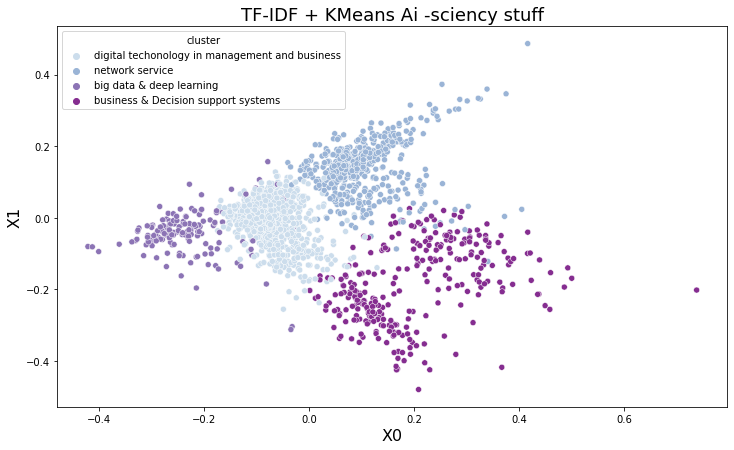

In [190]:
# set image size
plt.figure(figsize=(12, 7))
# set a title
plt.title("TF-IDF + KMeans Ai -sciency stuff", fontdict={"fontsize": 18})
# set axes names
plt.xlabel("X0", fontdict={"fontsize": 16})
plt.ylabel("X1", fontdict={"fontsize": 16})
# create scatter plot with seaborn, where hue is the class used to group the data
sns.scatterplot(data=auth_list, x='x0', y='x1', hue='cluster', palette="BuPu")
plt.show()

In [191]:
## Supervised ML 

In [192]:
X = ab_list['cleaned']

In [193]:
X = X.reset_index().drop(['index'], axis=1)

In [194]:
X = pd.DataFrame(X)

In [195]:
X.shape

(2000, 1)

In [196]:
y.value_counts()

2    1035
1     510
3     295
0     160
Name: labels, dtype: int64

### Sampling in sml

In [197]:
X.shape

(2000, 1)

In [198]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)

In [199]:
X_res.head()

,cleaned
0,paper addresses oil spill detection remotely s...
1,mobile business intelligence bi denotes delive...
2,although large firms already begun addressing ...
3,data warehouses major component data driven de...
4,paper sams novel health information system arc...


In [200]:
y_res.value_counts()

0    160
1    160
2    160
3    160
Name: labels, dtype: int64

In [201]:
X_train, X_test, y_train, y_test = train_test_split(X_res,y_res)

In [202]:
X_train.shape

(480, 1)

In [203]:
X_test.shape

(160, 1)

In [204]:
X_train.shape


(480, 1)

In [205]:
tfidf =  TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.95, ngram_range=(1,2))
cls = LogisticRegression(class_weight='balanced')

pipe = make_pipeline(tfidf, cls)


In [206]:
pipe.fit(X_train['cleaned'],y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_df=0.95, min_df=5, ngram_range=(1, 2),
                                 sublinear_tf=True)),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced'))])

In [207]:
y_eval = pipe.predict(X_train['cleaned'])
report = classification_report(y_train, y_eval)
y_pred = pipe.predict(data_tm['text_clean'])
print(report)

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       119
           1       0.96      0.96      0.96       124
           2       0.96      0.94      0.95       120
           3       0.97      0.97      0.97       117

    accuracy                           0.96       480
   macro avg       0.96      0.96      0.96       480
weighted avg       0.96      0.96      0.96       480



In [208]:
y_pred = pipe.predict(X_test['cleaned'])
report = classification_report(y_test, y_pred)

print(report)

              precision    recall  f1-score   support

           0       0.93      0.93      0.93        41
           1       0.52      0.69      0.60        36
           2       0.67      0.50      0.57        40
           3       0.63      0.60      0.62        43

    accuracy                           0.68       160
   macro avg       0.69      0.68      0.68       160
weighted avg       0.69      0.68      0.68       160



In [209]:
data_cl['labels']= pipe.predict(data_tm['text_clean'])
data_cl['labels'] = data_cl['labels'].map(cluster_map)

In [210]:
data_cl.head()

,Authors,Author(s) ID,Title,Year,Affiliations,Abstract,Author Keywords,text_clean,tokens,labels
0,"Dandachi G., Cerf S., Hadjadj-Aoul Y., Outtaga...",56705485700;57192995977;55663651600;5541631430...,A robust control-theory-based exploration stra...,2022,"INRIA, Univ Rennes, CNRS, IRISA, Rennes, Franc...","Network slice management and, more generally, ...",5G slicing; Control theory; Deep reinforcement...,network slice management generally resource or...,"[network, slice, management, generally, orches...",digital techonology in management and business
1,"Alshadoodee H.A.A., Mansoor M.S.G., Kuba H.K.,...",57211239907;57204473203;57217210777;57210428348;,The role of artificial intelligence in enhanci...,2022,"Department of Geography, Faculty of Arts, Univ...",This study illustrates the role of artificial ...,Artificial intelligence; Business intelligence...,study illustrates role artificial intelligence...,"[study, role, artificial, intelligence, admini...",big data & deep learning
2,"Krishnamoorthy M., Karthikeyan R.",7005169813;57211159213;,Pattern mining algorithms for data streams usi...,2022,Department of Computer Science and Engineering...,Knowledge discovery and data mining are fast g...,Data mining; Datasets; Machine learning algori...,knowledge discovery data mining fast growing f...,"[knowledge, discovery, data, mining, fast, fie...",digital techonology in management and business
3,"Gupta S., Modgil S., Kumar A., Sivarajah U., I...",55851943244;55314774400;57221973593;5620205430...,Artificial intelligence and cloud-based Collab...,2022,"Department of Information Systems, Supply Chai...",Natural disasters are often unpredictable and ...,Artificial intelligence; Cloud technologies; D...,natural disasters unpredictable need quick eff...,"[natural, disaster, unpredictable, quick, effe...",network service
4,"Ancín M., Pindado E., Sánchez M.",55584305100;57074832900;57194845281;,New trends in the global digital transformatio...,2022,Department of Business Management and Institut...,CONTEXT: The agri-food system is undergoing pe...,Agri-food sector; Agriculture 4.0; Data mining...,context agri food system undergoing pervasive ...,"[context, agri, food, system, pervasive, chang...",business & Decision support systems


In [211]:
data_cl = data_cl[['labels', 'Abstract']]

In [212]:
data_cl

,labels,Abstract
0,digital techonology in management and business,"Network slice management and, more generally, ..."
1,big data & deep learning,This study illustrates the role of artificial ...
2,digital techonology in management and business,Knowledge discovery and data mining are fast g...
3,network service,Natural disasters are often unpredictable and ...
4,business & Decision support systems,CONTEXT: The agri-food system is undergoing pe...
...,...,...
9413,big data & deep learning,"With the rapid economic operation, intensified..."
9414,big data & deep learning,Urmia Lake in Iran is the second largest salin...
9415,big data & deep learning,Health care decision makers and researchers of...
9416,big data & deep learning,"In the construction bonding business, a comple..."


In [213]:
data_cl.T

,0,1,2,3,4,6,7,8,9,10,...,9408,9409,9410,9411,9412,9413,9414,9415,9416,9417
labels,digital techonology in management and business,big data & deep learning,digital techonology in management and business,network service,business & Decision support systems,big data & deep learning,network service,network service,big data & deep learning,network service,...,big data & deep learning,business & Decision support systems,business & Decision support systems,big data & deep learning,big data & deep learning,big data & deep learning,big data & deep learning,big data & deep learning,big data & deep learning,digital techonology in management and business
Abstract,"Network slice management and, more generally, ...",This study illustrates the role of artificial ...,Knowledge discovery and data mining are fast g...,Natural disasters are often unpredictable and ...,CONTEXT: The agri-food system is undergoing pe...,Background: Although lung protective strategy ...,Context.: Especially web-facing software syste...,Painting is the largest energy consumption uni...,The aim of this paper is to assess the level o...,"This paper presents the results of a survey, c...",...,This paper proposes a novel combination of art...,This paper provides a survey of motion plannin...,"In this paper, we present methods for face rec...","Since the use of computers in business world, ...",As market globalization has changed the nature...,"With the rapid economic operation, intensified...",Urmia Lake in Iran is the second largest salin...,Health care decision makers and researchers of...,"In the construction bonding business, a comple...",Inappropriate effort of web manipulation or sp...


In [214]:
y_pred.shape

(160,)

# Method to identify rows that cause issues when exploding/merging datasets


After exploding the datasets based on authors and authors_id, it became evident that some rows included more authors than authors_id, hence creating issues when merging the datasets. It it assessed that the reason for this imbalance are authors with no/missing ids.

In order to avert the issues, the following method was utilized to identify rows with more authors than authors_id.

After exploding and merging the datasets, a new column 'Match' was created, comparing the title column from the authors dataframe and the title from the authors_id dataframe. The dataframe was then sorted based on the 'Match' column to identify the exact row where an imbalance occured (i.e. where match is false). The identified row was then dropped from the orignal dataframe and the process repeated, identifying and dropping 12 rows with imbalanced authors and authors_id.

The result (rows to be dropped) was then added to the initial cleaning of the data in section Network analysis / Preprocessing data

Below lines where utilized after merging the datasets in section Network Analysis / Merging exploded datasets and subsequenlty moved to the bottom of the notebook for explanatory purposes (since the rows are now dropped in the preprocessing section of network analysis, the lines do not yield a result anymore)

In [ ]:
data_na['Match'] = data_na['Title'] == data_na['Title_x']

In [ ]:
data_na.loc[data_na['Match'] == False]